# Sales Forcast using FbProphet

To learn more about Fb Prophet, please refer to https://www.facebook.com/gpa/facebook-protect

Data:
This dataset is from a UK retailer and can be downloaded from Kaggle. The dataset ranges from 2008 to 2011.

Desciption of variables:
* InvoiceDate- Date and time of the purchase.
* InvoiceNo - Invoice identification number.
* StockCode- Stock code for the product.
* Description - Brief description of the product.
* Quantity - Quantity of items purchased.
* UnitPrice - Unit price for a given product in Pounds Sterling.
* CurtomerID - ID of the customer making the purchase.
* Country - Country where the purchase was made.

In [ ]:
# Load the data file from local disk to Colab env. Run the following command and select the csv file to upload
from google.colab import files
datafile = files.upload()

In [ ]:
# install relevant, necessary packages
!pip install pandas
!pip install numpy
!pip install prophet
!pip install plotnine

In [ ]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [ ]:
# Let's convert the datafile into a dataframe
df = pd.read_csv('sales_data.csv', encoding='latin-1') # important to specify encoding

In [ ]:
# check total number of cells, first few rows, and descriptive stats 
def descriptive_info(df):
  number_of_cells = df.count(axis=0, level=None, numeric_only=False)
  print('Total number of cells the datafile has: \n' + str(number_of_cells))
  print('\n')
  print('Printing descriptive statistics...\n\n', df.describe())


In [ ]:
# Let's transform into datetime & look at the first few rows of our dataset
def _trans_date_time(df):
  df.index = pd.to_datetime(df['InvoiceDate'], infer_datetime_format=True)
  df.drop('InvoiceDate', axis=1, inplace=True)
  return df

In [ ]:
_trans_date_time(df) # don't run the function multiple times, it'll casue an error

As we can see, this datafile is not in the correct fbProphet format. We need some work to preapre it in the correct format. 

In [ ]:
# Let's check the shape of the dataset
# df.shape(0) for row numbers, # df.shape(1) for column numbers
print('Features:', df.shape[1],';', 'Entries:', df.shape[0]) 

In [ ]:
# then, we need to check for missing values, especially if that's too high, we'll need to take care of it
(df.isnull().sum()/ df.shape[0]).sort_values(ascending=False)

We see that we've almost 25% of missing customer ID present. Because our dataset has more than 500k instances, we can get rid of the missing inputs without hurting  our analysis much.

In [ ]:
# First make a copy of the original data and drop missing values from the new datafile
df2 = df.copy()
df2.dropna(axis = 0, inplace =True)
df2.head()

In [ ]:
# check for missing values back again
# then, we need to check for missing values, especially if that's too high, we'll need to take care of it
(df2.isnull().sum()/ df.shape[0]).sort_values(ascending=False)

Good news! we got rid of all missing values

In [ ]:
# check the info for the new dataframe
df2.info()

We see that almost 100k instances have been deleted. Let's continue working with the new datafile. We'll create a new feature (column) for our time series analysis.

In [ ]:
# Before we go any further, we need to fix one more thing. Because quantity can't 
# be zero, any quantity = 0 means that must be an error. Thus, we'll drop all rows with quantity = 0

df2 = df2[df2.Quantity > 0]

In [ ]:
(df2['UnitPrice'] == 0).sum()

We see that 40 rows have unit price = 0. Again, unit price = 0 does not make sense. This must be an error and we need to take care of this like Quantity before.

In [ ]:
df2 = df2[df2.UnitPrice > 0]

In [ ]:
df2.info()

In [ ]:
# Now, let's calculate the new column that will show the total amount spent on a 
# particluar day on a specific product
df2['TotalAmount'] = df2['Quantity'] * df2['UnitPrice']

In [ ]:
# check the file again
df2.head()

Now, as you can see, we have data from the same day for different products, that a single customer may have purchased. For time series analysis, we need to do some work to prepare our dataset. 
let's create some features that will be useful for timeseries analysis.



In [ ]:
 
# creating new features to help with the Time Series Analysis
# to learn more the following conversion, check out the link below-
# https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.year.html

df2["Year"] = df2.index.year 
df2["Quarter"] = df2.index.quarter
df2["Month"] = df2.index.month
df2["Week"] = df2.index.week
df2["Weekday"] = df2.index.weekday
df2["Day"] = df2.index.day
df2["Dayofyear"] = df2.index.dayofyear
df2["Date"] = pd.DatetimeIndex(df2.index).date

In [ ]:
# Let's have a quick pick at our data including some descriptive stats
df2.head()

We are going to focus on the variable for daily total amount. But we need to group it first based on dates. For that, we'll create a vector with variables that we'll use for grouping. To keep track of the amount spent, we'll also group the "TotalAmount" variable

In [ ]:
# create vector with all grouping variables and use it for grouping Quantity and totalAmount
group_ = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day","StockCode"]

# now, group other variables using the above vector, we generate a new dataframe as df3
# where we group quantity and totalamount based on the group_ vector 
df3 = pd.DataFrame(df2.groupby(group_).Quantity.sum(), columns=["Quantity"])
# now let's also group the total amount column
df3["TotalAmount"] = df2.groupby(group_).TotalAmount.sum()
df3 = df3.reset_index()
df3.head()

In [ ]:
# Let's check the descriptive information for both variables
df3.loc[:, ["Quantity", "TotalAmount"]].describe()

In [ ]:
## function to Plot the prepared stock data

def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'Date'
Y = 'TotalAmount'
Label = "total amount"
Figsize = (16,8)
Title = "Daily total Amount Sold"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Total amount ($)'
_fig_plot(df3, X, Y)

The plot clearly shows that we have some outliers in our dataset. Let's handle those first bedore proceeding further

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'Date'
Y = 'Quantity'
Label = "quantity"
Figsize = (16,8)
Title = "Quantity of Products Sold Daily"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Quantity (N)'
_fig_plot(df3, X, Y)

We see that both quantity and total amount has some outliers and need to be taken care of.

In [ ]:
# identifying drop points based on quantile 1% and 99% for the amounttotal column
low_amount = df3.TotalAmount.quantile(0.01)
high_amount = df3.TotalAmount.quantile(0.99)
print((low_amount, high_amount))

In [ ]:
# identifying drop points for the Quantity column
low_quantity = df3.Quantity.quantile(0.01)
high_quantity = df3.Quantity.quantile(0.99)
print((low_quantity, high_quantity))

In [ ]:
# Let's keep a track of shape to count lost entries
samples = df3.shape[0]
print(samples)

In [ ]:
# Now, let's select entries bigger than the low quantity value and lower than
# the high quantity value to take care of those outliers and same for the total amount spent column
df3 = df3.loc[(df3.Quantity >= low_amount) & (df3.Quantity <= high_amount)]
df3 = df3.loc[(df3.TotalAmount >= low_amount) & (df3.TotalAmount <= high_amount)]

In [ ]:
# check how many rows we dropped
print('Dropped number of rows: ', (samples - df3.shape[0]), 'Current sample size: ', df3.shape[0])

In [ ]:
# Let's finanlize the data for time series prediction
# group the total amount by dates and convert date to a panda date-time format 
df4=df3.groupby('Date',as_index=False)['TotalAmount'].sum() # grouping
df4['Date'] = pd.to_datetime(df4['Date'], format="%Y-%m-%d") # converting to datetime

In [ ]:
df4.head()

In [ ]:
# This Function is to prepare the dataset for Fb Prophet
#ds, save the name of date column as ds
#y, save the name of column we are interested in as y
def prepare_data(df, ds, y):
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
  df = df[[ds, y]]
  df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
  print('The series is ready for use.\n')
  return df

In [ ]:
# Use the function to prepare the dataframe to feed into fbprophet
# df = series, ds = the time variable name from the dataframe (string), 
# y = intended variable name for prediction from the dataframe, (string)
df5 = prepare_data(df4, ds = 'Date', y = 'TotalAmount') 
print(df5.head())
print('')
print('The length of your series is: ', df5.shape[0])

In [ ]:
# plot the new dataframe to have a quick look
X = 'ds'
Y = 'y'
Label = "amount spent"
Figsize = (16,8)
Title = "Daily Total Amount Spent"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'total amount ($)'
_fig_plot(df5, X, Y)

In [ ]:
# create test dataset, remove last 30 days and keep it as our test
train = df5[:275]
test = df5[275:]

In [ ]:
# let's predict now, we can do it both ways, either on the complete dataset
# to predict on future days or can train on the train dataset and evaluate using test
# instantiate the model and fit the timeseries

prophet = Prophet(daily_seasonality=False,
                  growth='linear', 
#                  changepoints=None, 
                  n_changepoints=25, 
                  changepoint_range=0.8, 
                  yearly_seasonality='auto', 
                  weekly_seasonality='auto', 
                  holidays=None, 
                  seasonality_mode='additive', 
                  seasonality_prior_scale=10, 
                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05)
#                  mcmc_samples=0, 
#                  interval_width=0.8, 
#                  uncertainty_samples=1000, 
#                  stan_backend=None)
prophet.fit(train)

# create a future data frame 
future = prophet.make_future_dataframe(periods=30)
forecast = prophet.predict(future)

In [ ]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [ ]:
# Python
plot_plotly(prophet, forecast)

In [ ]:
print(len(forecast), len(train), len(df5))

Let's evaluate the model prediction now

In [ ]:
#y_true .rt\
print('Length of forcast series, train series, and original series: ', len(forecast), len(train), len(df5))
print(' ')
y_true= test['y'].values
y_pred = forecast['yhat'][-len(y_true):].values
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error: %.3f' % mae)

In [ ]:
# check the length for both sub-series
len(y_true), len(y_pred)

In [ ]:
# plot expected vs actual
import matplotlib.pyplot as pltt
from matplotlib.pyplot import figure
figure(figsize=(16, 8), dpi=80)

pltt.plot(df5['y'].values, label='Actual')
pltt.plot(forecast['yhat'].values, label='Predicted')
pltt.legend()
pltt.show()

In [ ]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [ ]:
# Now, let's use the built in fbprophet evaluation function and metrix

evaluation_model = cross_validation(prophet, initial='200 days', period='50 days', horizon = '25 days')

In [ ]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.head(5)

# Covid Spread Forecasting Using Fb Prophet

In [ ]:
!pip install requests
# install relevant, necessary packages
!pip install pandas
!pip install numpy
!pip install prophet
!pip install plotnine

In [ ]:
# import necessary libraries
import requests
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [ ]:
# define the function to download data 
def build_covid19_data():
    request_str = 'https://corona.lmao.ninja/v2/historical'
    response = requests.get(request_str)
    json_data = response.json() if response and response.status_code == 200 else None
    
    df = None
    for country in json_data:
        res = build_country_data(country)
        if df is None:
            df = pd.DataFrame(res)
            df.index = pd.DatetimeIndex(df['Report_Date'])
            df = df.drop('Report_Date', 1)
            df = df.sort_values(by=['Report_Date'])
        else:
            df_new = pd.DataFrame(res)
            df_new.index = pd.DatetimeIndex(df_new['Report_Date'])
            df_new = df_new.drop('Report_Date', 1)
            df_new = df_new.sort_values(by=['Report_Date'])
            df = df.merge(df_new, left_index=True, right_index=True)
    
    df.to_csv('covid19_data.csv')
    return df

In [ ]:
def build_country_data(country):
    res = []
    keys = country.get('timeline').get('cases').keys()
    for key in keys:
        target_entry = {}
        target_entry['Report_Date'] = key
        country_name = country.get('country')
        if country.get('province') != None:
            country_name = country_name + '_' + country.get('province')
        target_entry[country_name + '_cases'] = country.get('timeline').get('cases').get(key)
        target_entry[country_name + '_deaths'] = country.get('timeline').get('deaths').get(key)
        target_entry[country_name + '_recovered'] = country.get('timeline').get('recovered').get(key)
        res.append(target_entry)
    return res

In [ ]:
df = build_covid19_data()
df.head()

Afghanistan_cases  Afghanistan_deaths  Afghanistan_recovered  \
Report_Date                                                                 
2022-04-06              177974                7671                      0   
2022-04-07              177974                7671                      0   
2022-04-08              177974                7671                      0   
2022-04-09              177974                7671                      0   
2022-04-10              177974                7671                      0   

             Albania_cases  Albania_deaths  Albania_recovered  Algeria_cases  \
Report_Date                                                                    
2022-04-06          274055            3492                  0         265705   
2022-04-07          274108            3492                  0         265707   
2022-04-08          274136            3492                  0         265714   
2022-04-09          274191            3492                  0         265720   
2022-04-10          274219            3493                  0         265724   

             Algeria_deaths  Algeria_recovered  Andorra_cases  ...  \
Report_Date                                                    ...   
2022-04-06             6874                  0          40024  ...   
2022-04-07             6874                  0          40328  ...   
2022-04-08             6874                  0          40328  ...   
2022-04-09             6874                  0          40328  ...   
2022-04-10             6874                  0          40328  ...   

             Winter Olympics 2022_recovered  Yemen_cases  Yemen_deaths  \
Report_Date                                                              
2022-04-06                                0        11812          2144   
2022-04-07                                0        11812          2145   
2022-04-08                                0        11812          2146   
2022-04-09                                0        11813          2147   
2022-04-10                                0        11813          2147   

             Yemen_recovered  Zambia_cases  Zambia_deaths  Zambia_recovered  \
Report_Date                                                                   
2022-04-06                 0        317358           3967                 0   
2022-04-07                 0        317483           3967                 0   
2022-04-08                 0        317483           3967                 0   
2022-04-09                 0        317483           3967                 0   
2022-04-10                 0        317483           3967                 0   

             Zimbabwe_cases  Zimbabwe_deaths  Zimbabwe_recovered  
Report_Date                                                       
2022-04-06           246803             5453                   0  
2022-04-07           246870             5455                   0  
2022-04-08           246925             5457                   0  
2022-04-09           246925             5457                   0  
2022-04-10           246958             5457                   0  

[5 rows x 852 columns]

In [ ]:
from google.colab import files
df = build_covid19_data()
df.to_csv('covid19_data.csv', encoding = 'utf-8-sig')
files.download('covid19_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# let's load the data to colab and read it as a panda dataframe.
# Load the data file from local disk to Colab env. Run the following command and select the csv file to upload
from google.colab import files
datafile = files.upload()

Saving covid19_data.csv to covid19_data.csv


In [ ]:
# Let's convert the datafile into a dataframe
# Put the csv filename as filename
filename = 'covid19_data.csv'
df = pd.read_csv(filename, encoding = 'utf-8-sig') # important to specify encoding

In [ ]:
# check total number of cells, first few rows, and descriptive stats 
def descriptive_info(df):
#  number_of_cells = df.count(axis=0, level=None, numeric_only=False)
  # Let's check the shape of the dataset
  print('Features:', df.shape[1], ' ', 'Entries:', df.shape[0])
  print('\n\n')
  print('Printing descriptive statistics...\n\n', df.describe())

In [ ]:
# now check some basic info of our dataset
descriptive_info(df)

Features: 853   Entries: 30



Printing descriptive statistics...

        Afghanistan_cases  Afghanistan_deaths  Afghanistan_recovered  \
count          30.000000           30.000000                   30.0   
mean       178521.833333         7678.800000                    0.0   
std           331.756567            4.482918                    0.0   
min        177974.000000         7671.000000                    0.0   
25%        178309.250000         7676.000000                    0.0   
50%        178592.500000         7680.000000                    0.0   
75%        178839.750000         7683.000000                    0.0   
max        178905.000000         7684.000000                    0.0   

       Albania_cases  Albania_deaths  Albania_recovered  Algeria_cases  \
count      30.000000       30.000000               30.0      30.000000   
mean   274656.966667     3495.066667                0.0  265751.600000   
std       380.623217        1.507071                0.0      25.296313

In [ ]:
spike_cols = [col for col in df.columns if 'US' in col]

In [ ]:
print(spike_cols)

['USA_cases', 'USA_deaths', 'USA_recovered']


The analysis will be similar for all countries. Here we'll investigate the US data only. If interested, play around with other countries similarly.

In [ ]:
# let's EXTRACT COLUMSN WITH USA DATA
df_us = df[['Report_Date', 'USA_cases', 'USA_deaths', 'USA_recovered']]

In [ ]:
df_us.head()

Report_Date  USA_cases  USA_deaths  USA_recovered
0  2022-04-06   80255129      984260              0
1  2022-04-07   80302516      984953              0
2  2022-04-08   80390106      985593              0
3  2022-04-09   80402760      985732              0
4  2022-04-10   80412219      985757              0

In [ ]:
# This Function is to prepare the dataset for Fb Prophet
#ds, save the name of date column as ds
#y, save the name of column we are interested in as y
def prepare_data(df, ds, y):
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
  df = df[[ds, y]]
  df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
  print('The series is ready for use.\n')
  return df

In [ ]:
# Use the function to prepare the dataframe to feed into fbprophet
# df = series, ds = the time variable name from the dataframe (string), 
# y = intended variable name for prediction from the dataframe, (string)
df2 = prepare_data(df_us, ds = 'Report_Date', y = 'USA_cases') 
print(df2.head())
print('')
print('The length of your series is: ', len(df2))

The series is ready for use.

           ds         y
0  2022-04-06  80255129
1  2022-04-07  80302516
2  2022-04-08  80390106
3  2022-04-09  80402760
4  2022-04-10  80412219

The length of your series is:  30


In [ ]:
## function to Plot the prepared data
def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

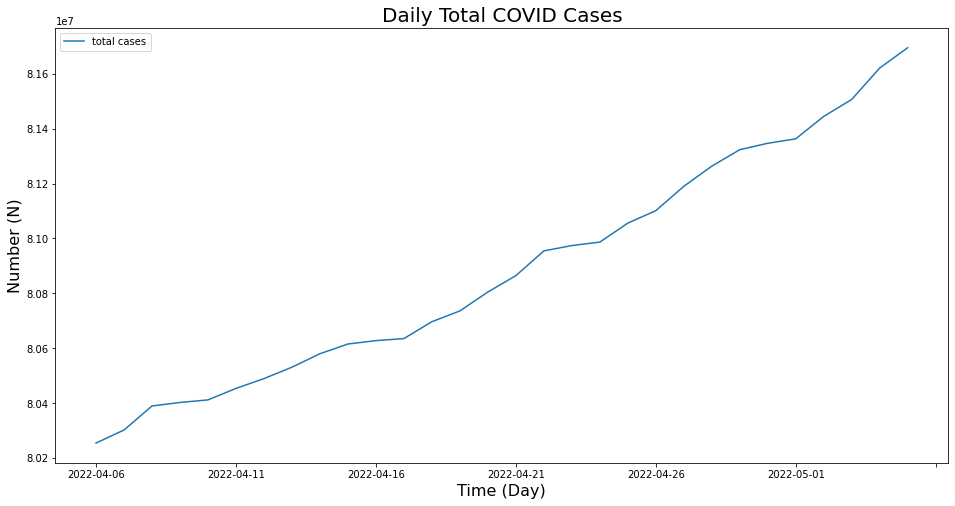

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'ds'
Y = 'y'
Label = "total cases"
Figsize = (16,8)
Title = "Daily Total COVID Cases"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Number (N)'
_fig_plot(df2, X, Y)

We see an overall increasing trend here. But no seasonality.



In [ ]:
# define training dataset
train = df2.copy()

In [ ]:
# Let's fit the model

prophet = Prophet(growth="linear",
            daily_seasonality= 'auto',
            weekly_seasonality= 'auto',
            yearly_seasonality= 'auto',
            changepoint_prior_scale=0.01)

prophet.fit(train)
future = prophet.make_future_dataframe(periods=30)
forecast = prophet.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.


Printing outputs from Prophet prediction...
           ds        yhat    yhat_lower    yhat_upper
0 2022-04-06  80255129.0  8.025513e+07  8.025513e+07
1 2022-04-07  80302516.0  8.030252e+07  8.030252e+07
2 2022-04-08  80390106.0  8.039011e+07  8.039011e+07
3 2022-04-09  80402760.0  8.040276e+07  8.040276e+07
4 2022-04-10  80412219.0  8.041222e+07  8.041222e+07


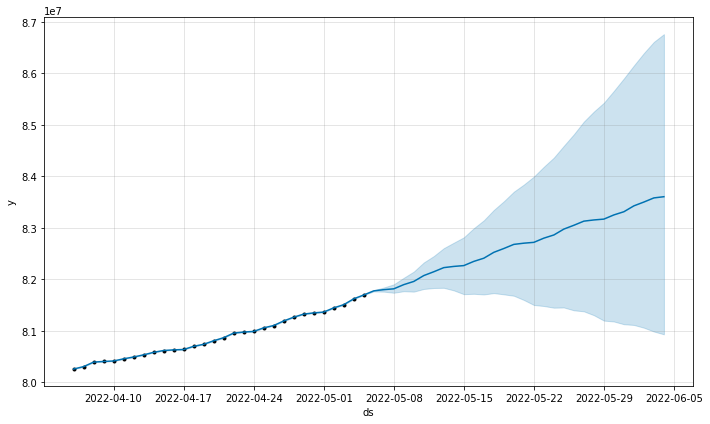

In [ ]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [ ]:
# Use the plot_plotly function to visualize prediction as seperate window size
plot_plotly(prophet, forecast)

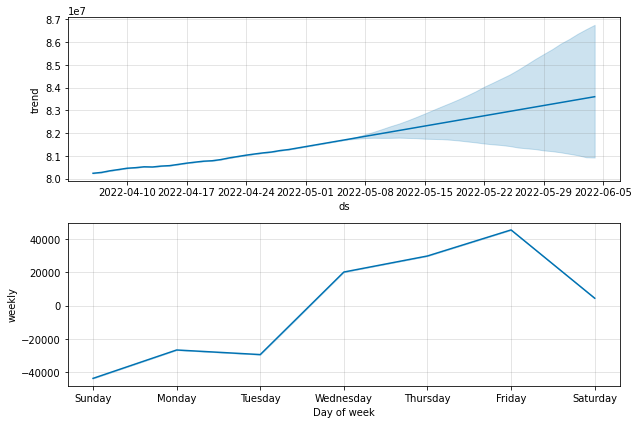

In [ ]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [ ]:
len(train)

30

In [ ]:
# use built in fbprophet evaluation function and metrix
evaluation_model = cross_validation(prophet, initial='20 days', period='4 days', horizon = '2 days')

INFO:prophet:Making 2 forecasts with cutoffs between 2022-04-29 00:00:00 and 2022-05-03 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:n_changepoints greater than number of observations. Using 21.


In [ ]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.sort_values('rmse').head()

horizon           mse          rmse           mae      mape     mdape  \
0  1 days  2.690079e+08  16401.459759  15514.924370  0.000190  0.000190   
1  2 days  2.883733e+08  16981.556337  16002.492154  0.000196  0.000196   

      smape  coverage  
0  0.000190       0.0  
1  0.000196       1.0

# Electricity Supply and Demand Forecasting Using FbProphet

Electricity demand and supply forcasting is an important part of seemless power management and business as well. For example, during the Summer, the demand for ari conditioner and other electrci equipments increase, and thus the electricity use and demand. Thus, predicting it has great economic importance as well.

Description of the dataset

Date range: 1 January 2015 - 6 October 2020. 

*** Description of columns. ***

* date : datetime, the date of the recording
* demand : float, a total daily electricity demand in MWh
* RRP : float, a recommended retail price in
* demand_pos_RRP : float, a total daily demand at positive RRP in MWh
* RRP_positive : float, an averaged positive RRP, weighted by the corresponding intraday demand in 
* demand_neg_RRP : float, an total daily demand at negative RRP in MWh
* RRP_negative : float, an average negative RRP, weighted by the corresponding * intraday demand in 
* frac_at_neg_RRP : float, a fraction of the day when the demand was traded at negative RRP
* min_temperature : float, minimum temperature during the day in Celsius
* max_temperature : float, maximum temperature during the day in Celsius
* solar_exposure : float, total daily sunlight energy in MJ/m^2
rainfall : float, daily rainfall in mm
* school_day : boolean, if students were at school on that day
* holiday : boolean, if the day was a state or national holiday
* unit = AUD$ / MWh



In [ ]:
# Load the data file from local disk to Colab env. Run the following command and select the csv file to upload
from google.colab import files
datafile = files.upload()

Saving electricity_complete_dataset.csv to electricity_complete_dataset (1).csv


In [ ]:
# install relevant, necessary packages
!pip install pandas
!pip install numpy
!pip install prophet
!pip install plotnine

In [ ]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [ ]:
# Let's convert the datafile into a dataframe
#  encoding='latin-1'
df = pd.read_csv('electricity_complete_dataset.csv') # important to specify encoding

In [ ]:
# check total number of cells, first few rows, and descriptive stats 
def descriptive_info(df):
  number_of_cells = df.count(axis=0, level=None, numeric_only=False)
  print('Total number of cells the datafile has: \n' + str(number_of_cells))
  print('\n')
  print('Printing descriptive statistics...\n\n', df.describe())

In [ ]:
# Let's check the shape of the dataset
# df.shape(0) for row numbers, # df.shape(1) for column numbers
print('Features:', df.shape[1],';', 'Entries:', df.shape[0]) 

Features: 14 ; Entries: 2106


In [ ]:
# then, we need to check for missing values, especially if that's too high, we'll need to take care of it
(df.isnull().sum()/ df.shape[0]).sort_values(ascending=False)

rainfall           0.001425
solar_exposure     0.000475
date               0.000000
demand             0.000000
RRP                0.000000
demand_pos_RRP     0.000000
RRP_positive       0.000000
demand_neg_RRP     0.000000
RRP_negative       0.000000
frac_at_neg_RRP    0.000000
min_temperature    0.000000
max_temperature    0.000000
school_day         0.000000
holiday            0.000000
dtype: float64

We see that our intended feature 'demand' and date have no missing values. That's a happy news. Let's continue to check some descriptive stats....

In [ ]:
# Let's check some descriptive stats of our dataset
descriptive_info(df)

Total number of cells the datafile has: 
date               2106
demand             2106
RRP                2106
demand_pos_RRP     2106
RRP_positive       2106
demand_neg_RRP     2106
RRP_negative       2106
frac_at_neg_RRP    2106
min_temperature    2106
max_temperature    2106
solar_exposure     2105
rainfall           2103
school_day         2106
holiday            2106
dtype: int64


Printing descriptive statistics...

               demand          RRP  demand_pos_RRP  RRP_positive  \
count    2106.000000  2106.000000     2106.000000   2106.000000   
mean   120035.476503    76.079554   119252.305055     76.553847   
std     13747.993761   130.246805    14818.631319    130.114184   
min     85094.375000    -6.076028    41988.240000     13.568986   
25%    109963.650000    38.707040   109246.250000     39.117361   
50%    119585.912500    66.596738   119148.082500     66.869058   
75%    130436.006250    95.075012   130119.477500     95.130181   
max    170653.840000  4549.645105  

In [ ]:
# before proceeding any further let's make a copy of our original data file
df2 = df.copy()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             2106 non-null   object 
 1   demand           2106 non-null   float64
 2   RRP              2106 non-null   float64
 3   demand_pos_RRP   2106 non-null   float64
 4   RRP_positive     2106 non-null   float64
 5   demand_neg_RRP   2106 non-null   float64
 6   RRP_negative     2106 non-null   float64
 7   frac_at_neg_RRP  2106 non-null   float64
 8   min_temperature  2106 non-null   float64
 9   max_temperature  2106 non-null   float64
 10  solar_exposure   2105 non-null   float64
 11  rainfall         2103 non-null   float64
 12  school_day       2106 non-null   object 
 13  holiday          2106 non-null   object 
dtypes: float64(11), object(3)
memory usage: 230.5+ KB


In [ ]:
# Now, let's prepare our dataset for forecasting 
# we'll define a function to do that. But before that,
# let's have a quick pick at our data
df2.head()


In [ ]:
## function to Plot the dependent variable vs time

def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

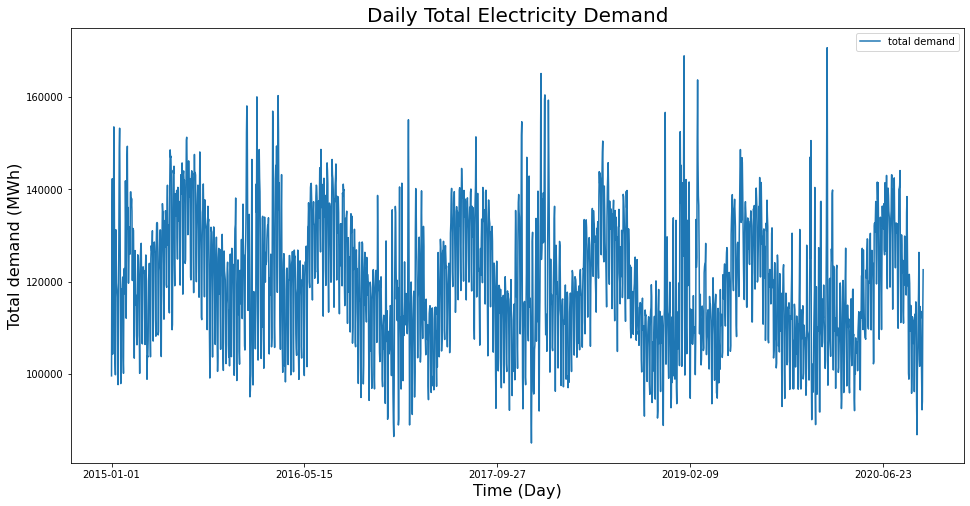

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'date' # the date variable
Y = 'demand' # predicted variable
Label = "total demand"
Figsize = (16,8)
Title = "Daily Total Electricity Demand"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Total demand (MWh)'
_fig_plot(df2, X, Y)

The plotted data shows daily,monthly and yearly seasonality. We need to keep that in mind when fitting our model. 
Now, let's prepare our data for prediction.

In [ ]:
# This Function is to prepare the dataset for Fb Prophet
#ds, save the name of date column as ds
#y, save the name of column we are interested in as y
def prepare_data(df, ds, y):
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
  df = df[[ds, y]]
  df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
  print('The series is ready for use.\n')
  return df

In [ ]:
# Use the function to prepare the dataframe to feed into fbprophet
# df = series, ds = the time variable name from the dataframe (string), 
# y = intended variable name for prediction from the dataframe, (string)
df3 = prepare_data(df2, ds = 'date', y = 'demand') 
print(df3.head())
print('')
print('The length of your series is: ', len(df3))

The series is ready for use.

           ds           y
0  2015-01-01   99635.030
1  2015-01-02  129606.010
2  2015-01-03  142300.540
3  2015-01-04  104330.715
4  2015-01-05  118132.200

The length of your series is:  2106


In [ ]:
# if interested can be used the built in holidays
import holidays 
holiday = pd.DataFrame([])
for date, name in sorted(holidays.AU(years=[2015,2016,2017,2018,2019,2020]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "AUS-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [ ]:
# we can either create test dataset, and remove last 100 days
# or can simply train the model on the complete dataset and predict 
# electricity demand in the future dates
train = df3[:]
#test = df3[2000:]

In [ ]:
# let's predict now
# instantiate the model and fit the timeseries

prophet = Prophet(daily_seasonality=False,
                  growth='linear', 
                  changepoints=None, 
                  n_changepoints=25, 
                  changepoint_range=0.8, 
                  yearly_seasonality=True, 
                  weekly_seasonality=True, 
                  seasonality_mode='additive', 
                  seasonality_prior_scale=10, 
                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05, 
                  mcmc_samples=0, 
                  interval_width=0.8, 
                  uncertainty_samples=1000, 
                  stan_backend=None)
prophet.fit(train)

# create a future data frame 
future = prophet.make_future_dataframe(periods=100)
forecast = prophet.predict(future)

Printing outputs from Prophet prediction...
           ds           yhat     yhat_lower     yhat_upper
0 2015-01-01  122790.993751  111791.691624  133729.266469
1 2015-01-02  121077.623365  110900.415583  132039.161616
2 2015-01-03  108293.366978   97353.533205  120523.072760
3 2015-01-04  104601.042981   93793.609239  116330.711277
4 2015-01-05  119853.607492  109013.929414  131909.661360


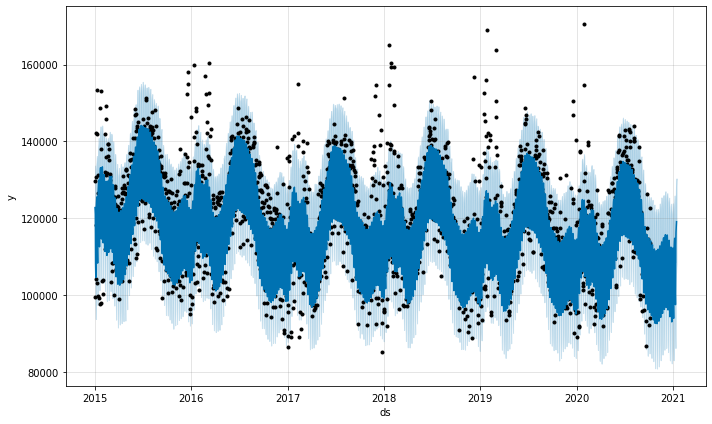

In [ ]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [ ]:
# Python
plot_plotly(prophet, forecast)

In [ ]:
print(len(forecast), len(train), len(df3))

2206 2106 2106


This following section can be used when we keep some data for testing. If we continue with the full dataset, Prophet built in evaluation methond is good enough for evaluation.

In [ ]:
#print('Length of forcast series, train series, and original series: ', len(forecast), len(train), len(df2))
#print(' ')
#y_true= test['y'].values
#y_pred = forecast['yhat'][:len(y_true)].values
#mae = mean_absolute_error(y_true, y_pred)
#print('Mean Absolute Error: %.3f' % mae)

Length of forcast series, train series, and original series:  2106 2000 2106
 
Mean Absolute Error: 11891.489


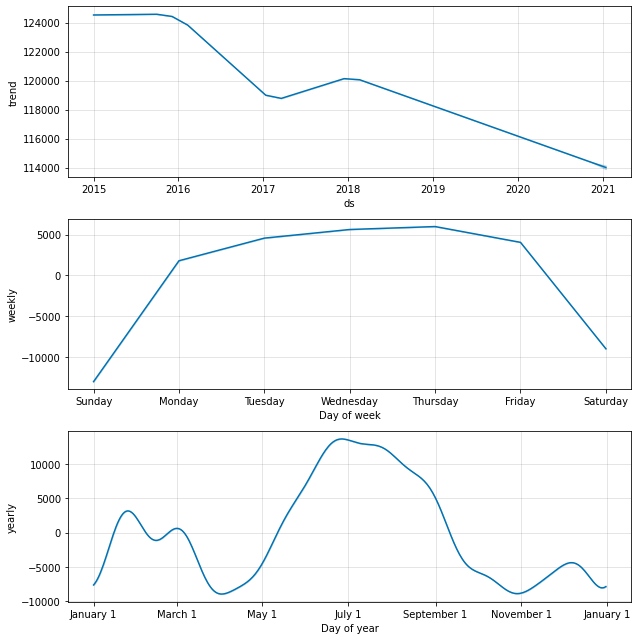

In [ ]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [ ]:
# Now, let's use the built in fbprophet evaluation function and metrix

evaluation_model = cross_validation(prophet, initial='1800 days', period='50 days', horizon = '25 days')

INFO:prophet:Making 6 forecasts with cutoffs between 2020-01-05 00:00:00 and 2020-09-11 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.head(5)

horizon           mse         rmse          mae      mape     mdape  \
0  3 days  7.919379e+07  8899.089494  8070.438367  0.070628  0.068116   
1  4 days  8.402548e+07  9166.541258  8584.889824  0.074781  0.072551   
2  5 days  6.066168e+07  7788.560578  7010.187110  0.061914  0.071008   
3  6 days  4.906026e+07  7004.302855  5838.871125  0.052286  0.048208   
4  7 days  5.038429e+07  7098.189140  5593.237284  0.051112  0.035359   

      smape  coverage  
0  0.069502  0.800000  
1  0.074115  0.766667  
2  0.061593  0.866667  
3  0.051787  0.833333  
4  0.049858  0.800000

# 

# Bike Rental Forecasting Using FbProphet

In this dataset, we have features that provide information on users bike ride volume, date of rides, Rain, and Temparature of that date.

We are going to predict the volume of bike ride in the future using time series analysis with Facebook Prophet.

In [ ]:
# let's load the data to colab and read it as a panda dataframe.
# Load the data file from local disk to Colab env. Run the following command and select the csv file to upload
from google.colab import files
datafile = files.upload()


Saving bikerides_day.csv to bikerides_day.csv


In [ ]:
# install relevant, necessary packages
!pip install pandas
!pip install numpy
!pip install prophet
!pip install plotnine

     |████████████████████████████████| 65 kB 2.5 MB/s 
     |████████████████████████████████| 49 kB 4.7 MB/s 
     |████████████████████████████████| 45 kB 2.7 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6639643 sha256=3cf9711778d100d117d3eb28b09fc9ea56225636e0d309bd022cf044fd708c20
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [ ]:
# Let's convert the datafile into a dataframe
# Put the csv filename as filename
filename = 'bikerides_day.csv'
df = pd.read_csv(filename) # important to specify encoding

In [ ]:
# check total number of cells, first few rows, and descriptive stats 
def descriptive_info(df):
#  number_of_cells = df.count(axis=0, level=None, numeric_only=False)
  # Let's check the shape of the dataset
  print('Features:', df.shape[1], ' ', 'Entries:', df.shape[0])
  print('\n\n')
  print('Printing descriptive statistics...\n\n', df.describe())

In [ ]:
# now check some basic info of our dataset
descriptive_info(df)

Features: 4   Entries: 1273



Printing descriptive statistics...

             Volume         Rain         Temp
count  1273.000000  1273.000000  1273.000000
mean   2609.344855     1.945640     6.783975
std    1968.623825     4.505151     7.726084
min      63.000000     0.000000   -11.400000
25%    1185.000000     0.000000     0.700000
50%    2073.000000     0.000000     5.500000
75%    3801.000000     1.400000    13.400000
max    8679.000000    39.500000    25.900000


In [ ]:
# Let's define a function to check the type of our features and check for 
# missing values in our dataset
def missing_val(df):
  print(df.info())
  print('\n\nFeatures with missing values in descending order \n\n')
  print((df.isnull().sum()/ df.shape[0]).sort_values(ascending=False))

In [ ]:
# Now apply the missing_val function
missing_val(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273 entries, 0 to 1272
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1273 non-null   object 
 1   Volume  1273 non-null   int64  
 2   Rain    1273 non-null   float64
 3   Temp    1273 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 39.9+ KB
None


Features with missing values in descending order 


Date      0.0
Volume    0.0
Rain      0.0
Temp      0.0
dtype: float64


Good news! We don't have any missing variables. We also see that we have 1273 inputs in our dataset. Let's continue.

In [ ]:
# This Function is to prepare the dataset for Fb Prophet
#ds, save the name of date column as ds
#y, save the name of column we are interested in as y
def prepare_data(df, ds, y):
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
  df = df[[ds, y]]
  df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
  print('The series is ready for use.\n')
  return df

In [ ]:
# Use the function to prepare the dataframe to feed into fbprophet
# df = series, ds = the time variable name from the dataframe (string), 
# y = intended variable name for prediction from the dataframe, (string)
df2 = prepare_data(df, ds = 'Date', y = 'Volume') 
print(df2.head())
print('')
print('The length of your series is: ', len(df2))

The series is ready for use.

           ds     y
0  11/17/2016   933
1  11/18/2016  1197
2  11/19/2016   243
3  11/20/2016   234
4  11/21/2016  2148

The length of your series is:  1273


In [ ]:
## function to Plot the prepared data
def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

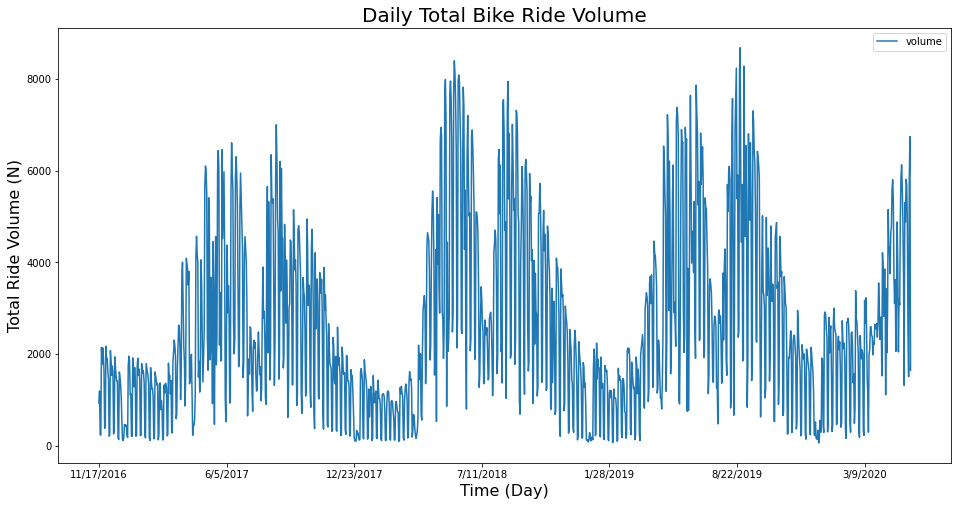

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'ds'
Y = 'y'
Label = "volume"
Figsize = (16,8)
Title = "Daily Total Bike Ride Volume"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Total Ride Volume (N)'
_fig_plot(df2, X, Y)

OK! The plot is very interesting. It clearly shows that we have some seasonality in our data. We see that in the Summer, the ride volume goes high each year. We'll have to keep that in mind while fitting our forecasting model. It doesn't have an obvious overall trend though. 

In [ ]:
shortX = df2[['ds', 'y']].tail(73)
shortX = shortX.rename(columns = {'ds': 'dss', 'y':'yss'}) 
#shortY = df2.loc[shortX]
shortX.head()
#print(len(shortX), len(shortY))

dss   yss
1200   3/9/2020  3171
1201  3/10/2020  2673
1202  3/11/2020  3228
1203  3/12/2020  2625
1204  3/13/2020  1506

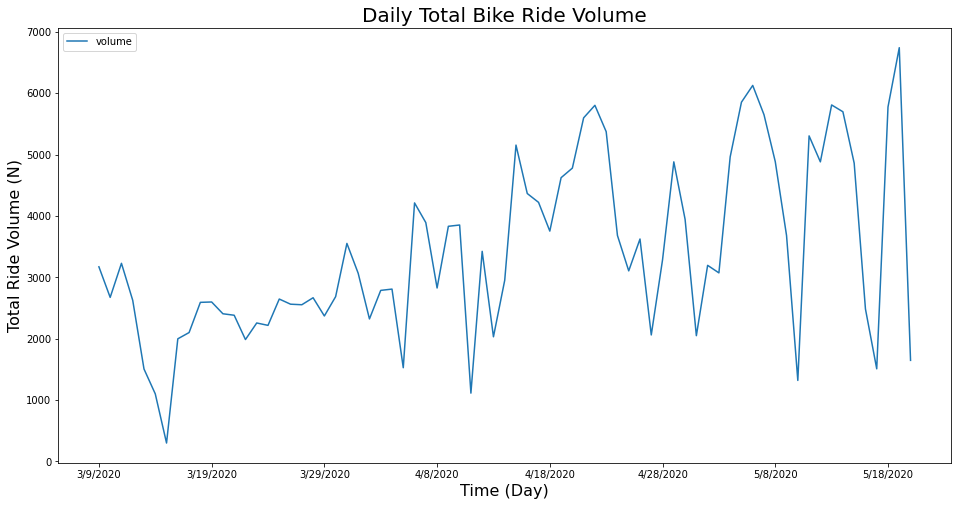

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'dss'
Y = 'yss'
Label = "volume"
Figsize = (16,8)
Title = "Daily Total Bike Ride Volume"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Total Ride Volume (N)'
_fig_plot(shortX, X, Y)

So, the dataset doesn't very clearly shows any daily seasonality or a consistant monthly seasonality. But as we discussed earlier, we got some yearly level seasonality.

In [ ]:
# define training dataset
train = df2.copy()

Available hyperparameters are-

* growth='linear', 
* changepoints=None, 
* n_changepoints=25, 
* changepoint_range=0.8, 
* yearly_seasonality='auto', 
* weekly_seasonality='auto', 
* daily_seasonality='auto', 
* holidays=None, 
* seasonality_mode='additive', 
* seasonality_prior_scale=10, 
* holidays_prior_scale=10, 
* changepoint_prior_scale=0.05, 
* mcmc_samples=0, 
* interval_width=0.8, 
* uncertainty_samples=1000, 
* stan_backend=None

In [ ]:
# let's predict now
# instantiate the model and fit the timeseries

prophet = Prophet(daily_seasonality= 'auto',
                  weekly_seasonality='auto',
                  yearly_seasonality='auto', 
                  growth='linear', 
                  changepoints=None, 
                  n_changepoints=25, 
                  changepoint_range=0.8,  
                  holidays=None, 
                  seasonality_mode='additive', 
                  seasonality_prior_scale=10, 
                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05, 
                  mcmc_samples=0, 
                  interval_width=0.8, 
                  uncertainty_samples=1000, 
                  stan_backend=None)
prophet.fit(train)

# create a future data frame 
future = prophet.make_future_dataframe(periods=100)
forecast = prophet.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Printing outputs from Prophet prediction...
           ds         yhat   yhat_lower   yhat_upper
0 2016-11-17  1953.775172   765.608993  3279.054269
1 2016-11-18  1542.395294   324.065978  2702.718566
2 2016-11-19  -172.714201 -1457.673535  1066.315445
3 2016-11-20   -90.395678 -1299.872820  1112.923193
4 2016-11-21  2281.121611  1107.844067  3599.971091


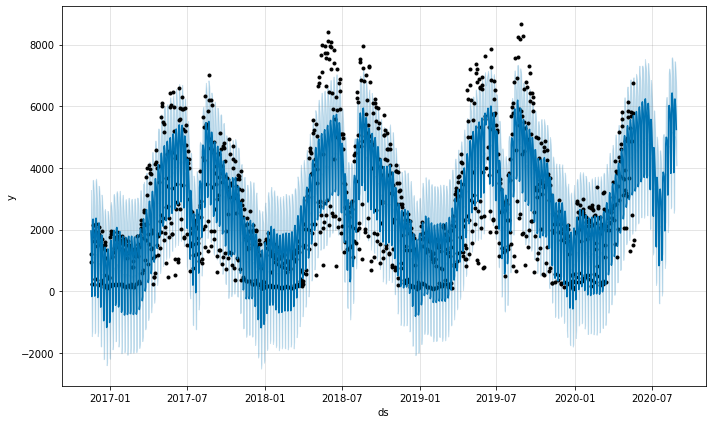

In [ ]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [ ]:
# Python
plot_plotly(prophet, forecast)

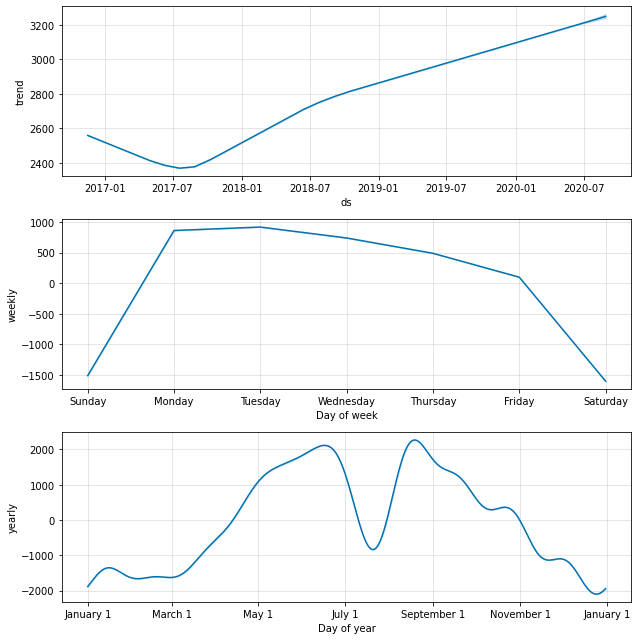

In [ ]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [ ]:
# use built in fbprophet evaluation function and metrix
evaluation_model = cross_validation(prophet, initial='800 days', period='50 days', horizon = '25 days')

INFO:prophet:Making 10 forecasts with cutoffs between 2019-01-31 00:00:00 and 2020-04-25 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.sort_values('rmse').head(5)

horizon            mse        rmse         mae      mape     mdape  \
8  11 days  446967.417697  668.556219  552.362672  0.606265  0.148912   
7  10 days  533019.859145  730.082091  572.017269  0.705642  0.223052   
9  12 days  555231.279762  745.138430  602.581479  0.467711  0.172173   
10 13 days  635076.442333  796.916835  603.254753  0.344443  0.172173   
15 18 days  705549.889647  839.970172  725.472371  0.657877  0.234903   

       smape  coverage  
8   0.458665      0.96  
7   0.574264      0.94  
9   0.329572      0.90  
10  0.243784      0.84  
15  0.593606      0.88

# Consumer Price forecasting Using FbProphet

In this exercise, we'll try to predict Consumer price Index uisng facebook prophet forecasting model.

In [ ]:
# install relevant, necessary packages
!pip install pandas
!pip install numpy
!pip install prophet
!pip install plotnine

In [ ]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error


In [ ]:
# First, we'll need to load the dataset as a panda dataframe. Let's do that.
# We'll define a function to fatch data from the web

def get_cpi_data(start, end):
  cpi = web.DataReader('CPILEGNS', 'fred', start, end)
  print('CPI data has been downloaded')
  return cpi

In [ ]:
import datetime

In [ ]:
# define start date and end date for data download
start = datetime.date(1987,1,1)
end = datetime.date.today()

df = get_cpi_data(start, end)

CPI data has been downloaded


In [ ]:
df.head()

CPILEGNS
DATE                
1987-01-01     115.0
1987-02-01     115.3
1987-03-01     115.8
1987-04-01     116.4
1987-05-01     116.7

we see that our dataset shows only one column. This is because our date column is
currently put as index. we need to convert it to datetime format. Let's do that.

In [ ]:
# Let's transform into datetime & look at the first few rows of our dataset
df.reset_index(inplace=True)

In [ ]:
df.head()

DATE  CPILEGNS
0 1987-01-01     115.0
1 1987-02-01     115.3
2 1987-03-01     115.8
3 1987-04-01     116.4
4 1987-05-01     116.7

Now, our data needs to be prepared to feed into Prophet.

In [ ]:
# This Function is to prepare the dataset for Fb Prophet
#ds, save the name of date column as ds
#y, save the name of column we are interested in as y
def prepare_data(df, ds, y):
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
  df = df[[ds, y]]
  df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
  firstdate = df['ds'].iloc[0]
  lastdate = df['ds'].iloc[-1]
  print('The series is ready for use.\n\nFirst and last date in your date column are: ', firstdate, lastdate)
  return df

In [ ]:
# Use the function to prepare the dataframe to feed into fbprophet
# df = series, ds = the time variable name from the dataframe (string), 
# y = intended variable name for prediction from the dataframe, (string)
df2 = prepare_data(df, ds = 'DATE', y = 'CPILEGNS') 
print(df2.head())
print('')
print('The length of your series is: ', len(df2))

The series is ready for use.

First and last date in your date column are:  1987-01-01 00:00:00 2022-03-01 00:00:00
          ds      y
0 1987-01-01  115.0
1 1987-02-01  115.3
2 1987-03-01  115.8
3 1987-04-01  116.4
4 1987-05-01  116.7

The length of your series is:  423


We see that our data ranges from January 1987 to March 2022. 

In [ ]:
# check the descriptive information for our focused variable
df2.loc[:, ["y"]].describe()

y
count  423.000000
mean   196.500752
std     44.838471
min    115.000000
25%    160.200000
50%    194.700000
75%    233.360000
max    289.456000

In [ ]:
# check for missing values back again
# then, we need to check for missing values, especially if that's too high, we'll need to take care of it
(df2.isnull().sum()/ df.shape[0]).sort_values(ascending=False)

ds    0.0
y     0.0
dtype: float64

No missing values, wonderful news!

In [ ]:
## function to Plot the prepared data

def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

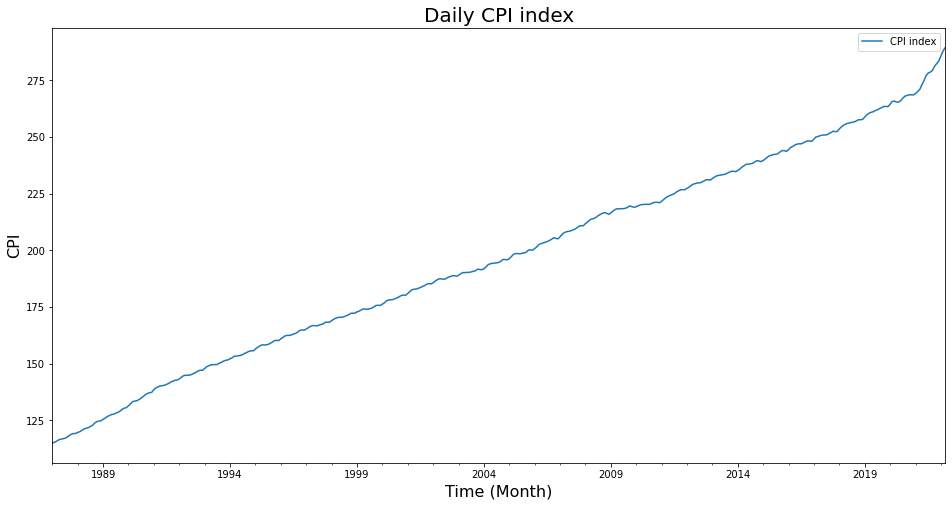

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'ds'
Y = 'y'
Label = "CPI index"
Figsize = (16,8)
Title = "Monthly CPI index"
xAxisLabel = 'Time (Month)'
yAxisLabel = 'CPI' # a ratio, unitless usually
_fig_plot(df2, X, Y)

Visually, it looks like an upward trend without any seasonality. Let's plot a shorter window.

In [ ]:
shortX = df2[['ds', 'y']].tail(50)
shortX = shortX.rename(columns = {'ds': 'dss', 'y':'yss'}) 
shortX.head()

dss      yss
373 2018-02-01  254.555
374 2018-03-01  255.275
375 2018-04-01  255.750
376 2018-05-01  256.112
377 2018-06-01  256.325

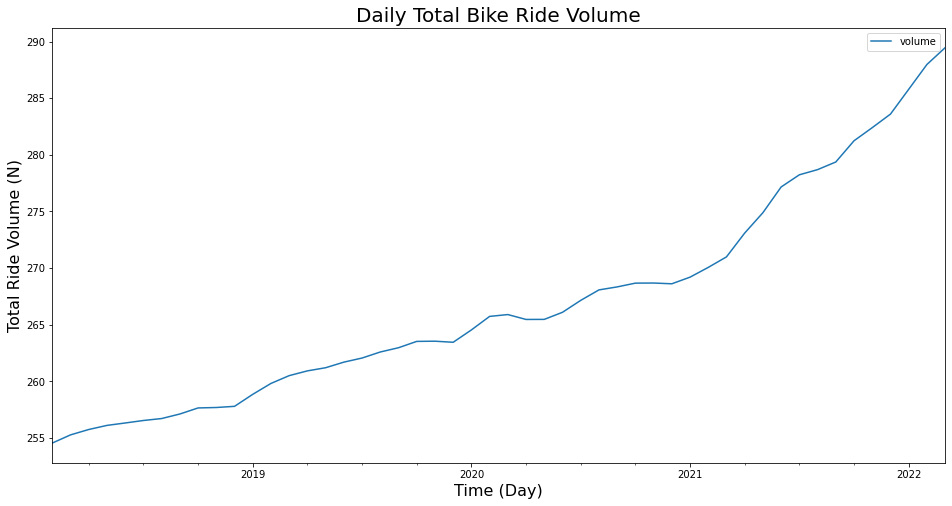

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'dss'
Y = 'yss'
Label = "CPI index"
Figsize = (16,8)
Title = "Monthly CPI Index"
xAxisLabel = 'Time (Month))'
yAxisLabel = 'CPI'
_fig_plot(shortX, X, Y)

Now, we see some yearly seasonality. At the beginning of each year, the slope goes downward. We need to use this info while building our prediction model using fbprophet. 

In [ ]:
# We can either create a test dataset by removing some data from the end
# Or we can use the built in evaluation function from Prophet, here we use the 
# built in function, if you want to do it manually, that's also possible
train = df2.copy()

Available hyperparameters are-

* growth='linear', 
* changepoints=None, 
* n_changepoints=25, 
* changepoint_range=0.8, 
* yearly_seasonality='auto', 
* weekly_seasonality='auto', 
* daily_seasonality='auto', 
* holidays=None, 
* seasonality_mode='additive', 
* seasonality_prior_scale=10, 
* holidays_prior_scale=10, 
* changepoint_prior_scale=0.05, 
* mcmc_samples=0, 
* interval_width=0.8, 
* uncertainty_samples=1000, 
* stan_backend=None

In [ ]:
# let's predict now
# instantiate the model and fit the timeseries

prophet = Prophet(daily_seasonality= 'auto',
                  weekly_seasonality='auto',
                  yearly_seasonality=True, 
                  growth='linear', 
                  changepoints=None, 
                  n_changepoints=25, 
                  changepoint_range=0.8,  
                  holidays=None, 
                  seasonality_mode='additive', 
                  seasonality_prior_scale=10, 
                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05, 
                  mcmc_samples=0, 
                  interval_width=0.8, 
                  uncertainty_samples=1000, 
                  stan_backend=None)
prophet.fit(train)

# create a future data frame 
future = prophet.make_future_dataframe(periods=12, freq='MS') # we make prediction for next 1 year
forecast = prophet.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Printing outputs from Prophet prediction...

           ds        yhat  yhat_lower  yhat_upper
0 1987-01-01  114.006203  112.361597  115.598549
1 1987-02-01  114.821225  113.192384  116.591515
2 1987-03-01  115.848549  114.323237  117.479579
3 1987-04-01  115.870762  114.237962  117.539434
4 1987-05-01  116.157786  114.636789  117.763000


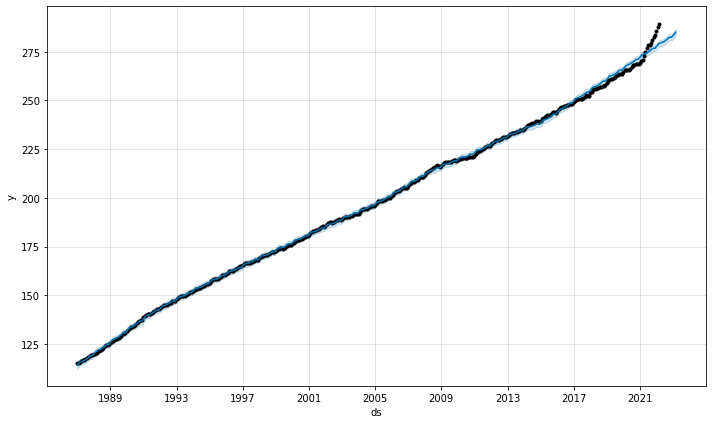

In [ ]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [ ]:
# let's use the function to plot it to be able to visualize in different windows
plot_plotly(prophet, forecast)

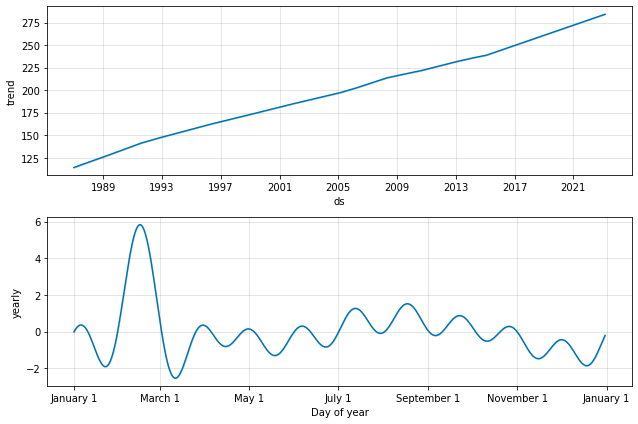

In [ ]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [ ]:
firstdate = forecast['ds'].iloc[0]
lastdate = forecast['ds'].iloc[-1]
print('First and last date in your date column are: ', firstdate, lastdate)

First and last date in your date column are:  1987-01-01 00:00:00 2023-03-01 00:00:00


For more info on cross validation, check-
https://datascience.stackexchange.com/questions/69277/how-fbprophet-cross-validation-works

In [ ]:
# use built in fbprophet evaluation function and metrix
# Because our time unit is month, we need to take a different approach for validation check
# first, define a cutoff range, leaving some initial months for training
# We are doing cross validation with a forecast horizon (frequency of prediction) of 3 months, 
# starting with 31 years of training data and then moving forward with a period of 2 months.
cutoffs = pd.date_range(start='2018-01-01', end='2021-12-31', freq='1MS')

evaluation_model = cross_validation(prophet, horizon='90 days', cutoffs=cutoffs)

  0%|          | 0/48 [00:00<?, ?it/s]

Let's evaluate our predictions now using the built in evaluation function from Prophet.

In [ ]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.head(5)

horizon        mse      rmse       mae      mape     mdape     smape  \
0 30 days  11.754381  3.428466  2.251880  0.008190  0.003950  0.008266   
1 31 days  10.217134  3.196425  2.067133  0.007540  0.004183  0.007606   
2 59 days   5.157091  2.270923  1.537550  0.005698  0.003038  0.005732   
3 60 days   3.244373  1.801214  1.256604  0.004689  0.003081  0.004710   
4 61 days  14.251174  3.775073  2.484310  0.009015  0.004177  0.009106   

   coverage  
0  0.062500  
1  0.071429  
2  0.028571  
3  0.114286  
4  0.062500

The evaluation result shows a very good model.

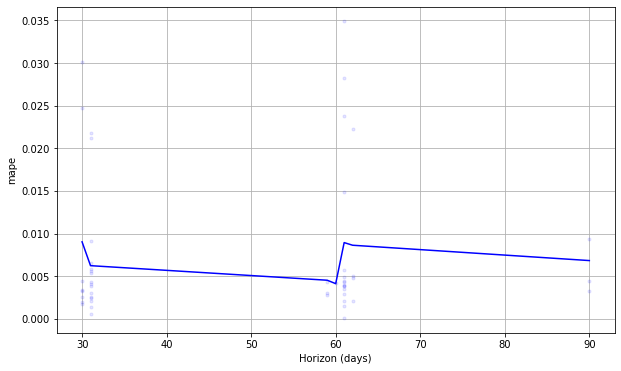

In [ ]:
#Cross validation performance metrics can be visualized with plot_cross_validation_metric, here shown for MAPE. 
# Dots show the absolute percent error for each prediction in df_cv.
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(evaluation_model, metric='mape')


Overall, it shows a good prediction model.

# Crime rate forecasting Using FbProphet


In [ ]:
# install relevant, necessary packages
!pip install pandas
!pip install numpy
!pip install prophet
!pip install plotnine

In [ ]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [ ]:
# Load the data file from local disk to Colab env. Run the following command and select the csv file to upload
from google.colab import files
datafile = files.upload()

In [ ]:
# read the datafile as a panda dataframe
df = pd.read_csv('Chicago_Crimes_2001_to_2004.csv')

In [ ]:
df.head(2)

Unnamed: 0        ID Case Number                    Date  \
0           3  10508693    HZ250496  05/03/2016 11:40:00 PM   
1          89  10508695    HZ250409  05/03/2016 09:40:00 PM   

                Block  IUCR Primary Type              Description  \
0  013XX S SAWYER AVE  0486      BATTERY  DOMESTIC BATTERY SIMPLE   
1  061XX S DREXEL AVE  0486      BATTERY  DOMESTIC BATTERY SIMPLE   

  Location Description  Arrest  ...  Ward  Community Area  FBI Code  \
0            APARTMENT    True  ...  24.0            29.0       08B   
1            RESIDENCE   False  ...  20.0            42.0       08B   

   X Coordinate  Y Coordinate  Year              Updated On   Latitude  \
0     1154907.0     1893681.0  2016  05/10/2016 03:56:50 PM  41.864073   
1     1183066.0     1864330.0  2016  05/10/2016 03:56:50 PM  41.782922   

   Longitude                       Location  
0 -87.706819  (41.864073157, -87.706818608)  
1 -87.604363   (41.782921527, -87.60436317)  

[2 rows x 23 columns]

In [ ]:
# We have many columns that we are not going to use. Let's drop those first
df.drop(['Unnamed: 0', 'ID', 'Case Number', 'IUCR', 'X Coordinate',  'Y Coordinate','Updated On','Year', 'FBI Code', 'Beat','Ward','Community Area','Location', 'District', 'Latitude', 'Longitude'],
axis = 1, inplace=True)

In [ ]:
df.head()

Date                Block            Primary Type  \
0  05/03/2016 11:40:00 PM   013XX S SAWYER AVE                 BATTERY   
1  05/03/2016 09:40:00 PM   061XX S DREXEL AVE                 BATTERY   
2  05/03/2016 11:31:00 PM  053XX W CHICAGO AVE  PUBLIC PEACE VIOLATION   
3  05/03/2016 10:10:00 PM    049XX W FULTON ST                 BATTERY   
4  05/03/2016 10:00:00 PM    003XX N LOTUS AVE                   THEFT   

               Description Location Description  Arrest  Domestic  
0  DOMESTIC BATTERY SIMPLE            APARTMENT    True      True  
1  DOMESTIC BATTERY SIMPLE            RESIDENCE   False      True  
2         RECKLESS CONDUCT               STREET   False     False  
3                   SIMPLE             SIDEWALK   False     False  
4           $500 AND UNDER            RESIDENCE   False      True

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456714 entries, 0 to 1456713
Data columns (total 7 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   Date                  1456714 non-null  object
 1   Block                 1456714 non-null  object
 2   Primary Type          1456714 non-null  object
 3   Description           1456714 non-null  object
 4   Location Description  1455056 non-null  object
 5   Arrest                1456714 non-null  bool  
 6   Domestic              1456714 non-null  bool  
dtypes: bool(2), object(5)
memory usage: 58.3+ MB


In [ ]:
# let's convert the date column to the datetime format that is required by Prophet
df2 = df.copy()
df2.Date = pd.to_datetime(df2.Date, format = '%m/%d/%Y %I:%M:%S %p')
df2.index = pd.DatetimeIndex(df2.Date)
df2.drop('Date', inplace = True, axis = 1)

In [ ]:
df2.head()

Block            Primary Type  \
Date                                                               
2016-05-03 23:40:00   013XX S SAWYER AVE                 BATTERY   
2016-05-03 21:40:00   061XX S DREXEL AVE                 BATTERY   
2016-05-03 23:31:00  053XX W CHICAGO AVE  PUBLIC PEACE VIOLATION   
2016-05-03 22:10:00    049XX W FULTON ST                 BATTERY   
2016-05-03 22:00:00    003XX N LOTUS AVE                   THEFT   

                                 Description Location Description  Arrest  \
Date                                                                        
2016-05-03 23:40:00  DOMESTIC BATTERY SIMPLE            APARTMENT    True   
2016-05-03 21:40:00  DOMESTIC BATTERY SIMPLE            RESIDENCE   False   
2016-05-03 23:31:00         RECKLESS CONDUCT               STREET   False   
2016-05-03 22:10:00                   SIMPLE             SIDEWALK   False   
2016-05-03 22:00:00           $500 AND UNDER            RESIDENCE   False   

                     Domestic  
Date                           
2016-05-03 23:40:00      True  
2016-05-03 21:40:00      True  
2016-05-03 23:31:00     False  
2016-05-03 22:10:00     False  
2016-05-03 22:00:00      True

Now, let's look at the crime distribution on a monthly level

Text(0, 0.5, 'Num of crimes')

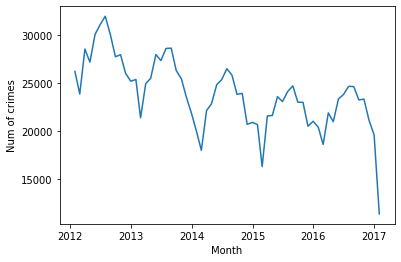

In [ ]:
plt.plot(df2.resample('M').size())
plt.xlabel('Month')
plt.ylabel('Num of crimes')

Text(0, 0.5, 'Num of crimes')

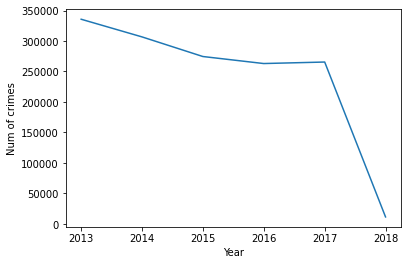

In [ ]:
plt.plot(df2.resample('Y').size())
plt.xlabel('Year')
plt.ylabel('Num of crimes')

We clearly see that overall there is a discending trend. But, while there is a monthly seasonality, there is no clear yearly seasonality. We need these information for modeling with Prophet.

Next, let's prepare our dataset for feeding into prophet. This requires a speific format. We need only two colums with 'ds' as our date column, and 'y' as the variable that we want to predict. 

We'll do it as a monthly data.

In [ ]:
# prepare the data
df3 = df2.resample('M').size().reset_index() # resample it to monthly data
df3.columns = ['Date', 'Monthly Crime Count']
df3 = df3.rename(columns = {'Date': 'ds', 'Monthly Crime Count': 'y'})

In [ ]:
df3.head()

ds      y
0 2012-01-31  26194
1 2012-02-29  23847
2 2012-03-31  28533
3 2012-04-30  27164
4 2012-05-31  30067

In [ ]:
## function to Plot the prepared stock data

def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

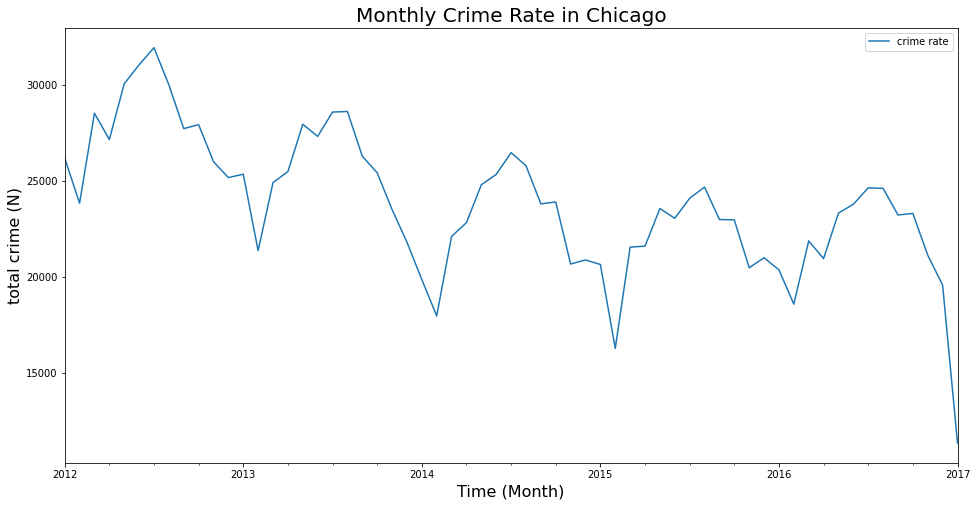

In [ ]:
# plot the new dataframe to check back
X = 'ds'
Y = 'y'
Label = "crime rate"
Figsize = (16,8)
Title = "Monthly Crime Rate in Chicago"
xAxisLabel = 'Time (Month)'
yAxisLabel = 'total crime (N)'
_fig_plot(df3, X, Y)

In [ ]:
# we can either input the full dataset and predict y in the future 
# or can split our dataset to train test. Here we continue with full data
train = df3.copy()

In [ ]:
# because we have monthly seasonality, we need to add that to our model prediction
prophet = Prophet(daily_seasonality=True,
                  growth='linear', 
                  changepoints=None, 
                  n_changepoints=25, 
                  changepoint_range=0.8, 
                  yearly_seasonality=False, 
                  weekly_seasonality='auto', 
                  holidays=None, 
                  seasonality_mode='additive', 
                  seasonality_prior_scale=10, 
                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05, 
                  mcmc_samples=0, 
                  interval_width=0.9, 
                  uncertainty_samples=1000, 
                  stan_backend=None)

# let's add monthly and quarterly seasonality to model better
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=10)
prophet.add_seasonality(name='quarterly', period=91.5, fourier_order=10)


prophet.fit(train)

# create a future data frame 
future = prophet.make_future_dataframe(periods=12, freq = 'MS')
forecast = prophet.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Printing outputs from Prophet prediction...
           ds          yhat    yhat_lower    yhat_upper
0 2012-01-31  26527.751016  22260.314693  30538.854051
1 2012-02-29  27771.816285  23727.678093  31743.844477
2 2012-03-31  27685.433111  23746.022740  31624.743001
3 2012-04-30  27546.168283  23354.031055  31460.031816
4 2012-05-31  28318.515554  24296.987738  32197.056595


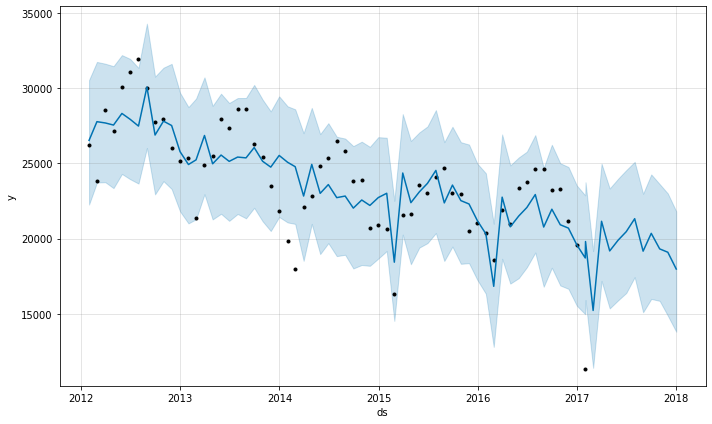

In [ ]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [ ]:
# Python
plot_plotly(prophet, forecast)

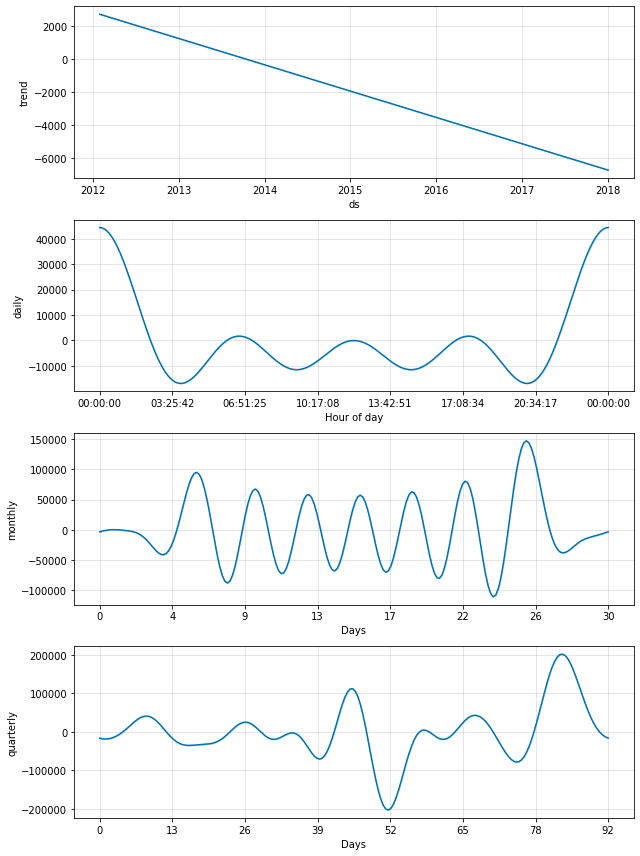

In [ ]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [ ]:
firstdate = forecast['ds'].iloc[0]
lastdate = forecast['ds'].iloc[-1]
print('First and last date in your date column are: ', firstdate, lastdate)

First and last date in your date column are:  2012-01-31 00:00:00 2018-01-01 00:00:00


In [ ]:
# use built in fbprophet evaluation function and metrix
# Because our time unit is month, we need to take a different approach for validation check
# first, define a cutoff range, leaving some initial months for training
# We are doing cross validation with a forecast horizon (frequency of prediction) of 3 months, 
# starting with 4 years of training data and then moving forward with a period of 1 month.
cutoffs = pd.date_range(start='2016-01-01', end='2017-06-30', freq='1MS')
evaluation_model = cross_validation(prophet, horizon='90 days', cutoffs=cutoffs)

In [ ]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.head(5)

In [ ]:
#Cross validation performance metrics can be visualized with plot_cross_validation_metric, here shown for MAPE. 
# Dots show the absolute percent error for each prediction in df_cv.
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(evaluation_model, metric='mape')

# Air Quality Forecasting Uning Fb Prophet

Some useful information regarding the dataset. The value column has following inputs. We'll continue with instances that record pm25.
To learn more about pm25, check out this Quora link- 
https://www.quora.com/What-does-PM-2-5-mean-in-air-pollution-and-how-is-it-measured

* pm10 - PM1.0 (dust particles with a size of 1 μm), mkg/cub.m
* pm25 - PM2.5 (dust particles with a size of 2.5 μm), mkg/cub.m
* CO2 - carbon dioxide, mkg/cub.m
* temperature - temperature, in degrees Celsius
* humidity - Humidity, %
* pressure - Pressure, millimeters of mercury.

In [ ]:
# install relevant, necessary packages
!pip install pandas
!pip install numpy
!pip install prophet
!pip install plotnine

In [ ]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [ ]:
# let's load the data to colab and read it as a panda dataframe.
# Load the data file from local disk to Colab env. Run the following command and select the csv file to upload
from google.colab import files
datafile = files.upload()

Saving saveecobot_1008.csv to saveecobot_1008.csv


In [ ]:
# Let's convert the datafile into a dataframe
# Put the csv filename as filename
filename = 'saveecobot_1008.csv'
df = pd.read_csv(filename) # important to specify encoding

In [ ]:
# check total number of cells, first few rows, and descriptive stats 
def descriptive_info(df):
#  number_of_cells = df.count(axis=0, level=None, numeric_only=False)
  # Let's check the shape of the dataset
  print('Features:', df.shape[1], ' ', 'Entries:', df.shape[0])
  print('\n\n')
  print('Printing descriptive statistics...\n\n', df.describe())

In [ ]:
# now check some basic info of our dataset
descriptive_info(df)

Features: 5   Entries: 1526453



Printing descriptive statistics...

        device_id         value  value_text
count  1526453.0  1.526453e+06         0.0
mean      1008.0  4.739664e+04         NaN
std          0.0  1.925751e+05         NaN
min       1008.0 -1.280000e+02         NaN
25%       1008.0 -1.000000e+00         NaN
50%       1008.0  2.105000e+01         NaN
75%       1008.0  8.300000e+01         NaN
max       1008.0  1.005700e+06         NaN


In [ ]:
# Let's define a function to check the type of our features and check for 
# missing values in our dataset
def missing_val(df):
  print(df.info())
  print('\n\nFeatures with missing values in descending order \n\n')
  print((df.isnull().sum()/ df.shape[0]).sort_values(ascending=False))

In [ ]:
# Now apply the missing_val function
missing_val(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526453 entries, 0 to 1526452
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   device_id   1526453 non-null  int64  
 1   phenomenon  1526453 non-null  object 
 2   value       1526453 non-null  float64
 3   logged_at   1526453 non-null  object 
 4   value_text  0 non-null        float64
dtypes: float64(2), int64(1), object(2)
memory usage: 58.2+ MB
None


Features with missing values in descending order 


value_text    1.0
device_id     0.0
phenomenon    0.0
value         0.0
logged_at     0.0
dtype: float64


In [ ]:
df.head()

device_id   phenomenon     value            logged_at  value_text
0       1008         pm10     34.43  2019-05-25 06:05:25         NaN
1       1008         pm25     23.22  2019-05-25 06:05:25         NaN
2       1008  temperature     19.19  2019-05-25 06:05:25         NaN
3       1008     humidity     77.25  2019-05-25 06:05:25         NaN
4       1008     pressure  98929.27  2019-05-25 06:05:25         NaN

In [ ]:
# We see that there are different phenomenon in our dataset. We are interesetd in
# keeping pm25 in our data. Let's do it now
df2 = df[df['phenomenon']== 'pm25']

In [ ]:
# This Function is to prepare the dataset for Fb Prophet
#ds, save the name of date column as ds
#y, save the name of column we are interested in as y
def prepare_data(df, ds, y):
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
  df = df[[ds, y]].reset_index(drop=True)
  df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
  df['ds'] =  pd.to_datetime(df['ds'], format='%Y-%m-%d %H:%M:%S', errors='ignore')
  print('The series is ready for use.\n')
  return df

In [ ]:
# Use the function to prepare the dataframe to feed into fbprophet
# df = series, ds = the time variable name from the dataframe (string), 
# y = intended variable name for prediction from the dataframe, (string)
df3 = prepare_data(df2, ds = 'logged_at', y = 'value') 
print(df3.head())
print('')
print('The length of your series is: ', len(df3))

The series is ready for use.

                   ds      y
0 2019-05-25 06:05:25  23.22
1 2019-05-25 06:08:00  23.85
2 2019-05-25 06:10:35  21.90
3 2019-05-25 06:13:09  19.77
4 2019-05-25 06:15:44  20.72

The length of your series is:  149212


We see that the data is recorded in every second. We'll aggregate that to make it per day.

In [ ]:
# aggregrate data per day
df3 = df3.resample('D', on='ds').sum()

In [ ]:
df3 = df3.dropna().reset_index(drop=False)
df3.tail(5)

ds        y
716 2021-05-10   641.91
717 2021-05-11    56.96
718 2021-05-12   289.33
719 2021-05-13  2375.46
720 2021-05-14   917.47

In [ ]:
## function to Plot the prepared data
def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

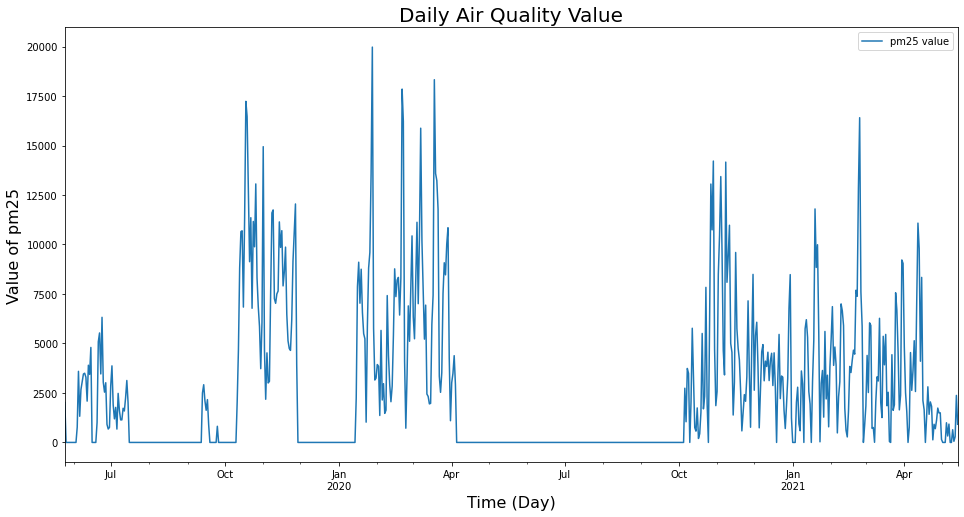

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'ds'
Y = 'y'
Label = "pm25 value"
Figsize = (16,8)
Title = "Daily Air Quality Value"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Value of pm25'
_fig_plot(df3, X, Y)

The data does not show any trend but it has some seasonality involved.

In [ ]:
# define training dataset
train = df3.copy()

In [ ]:
# let's predict now
# instantiate the model and fit the timeseries

prophet = Prophet(daily_seasonality= False,
                  weekly_seasonality= False,
                  yearly_seasonality=True, 
                  growth='linear', 
                  changepoints=None, 
                  n_changepoints=25, 
                  changepoint_range=0.8,  
                  holidays=None, 
                  seasonality_mode='multiplicative', 
                  seasonality_prior_scale=10, 
                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05, 
                  mcmc_samples=0, 
                  interval_width=0.8, 
                  uncertainty_samples=1000, 
                  stan_backend=None)
# let's add additional seasonalities
prophet.add_seasonality(name='weekly', period=7, fourier_order=3, 
                      mode = 'multiplicative', prior_scale = 0.25)
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=3, 
                      mode = 'multiplicative', prior_scale = 0.15)

prophet.fit(train)

# create a future data frame 
future = prophet.make_future_dataframe(periods=100, freq = 'D')
forecast = prophet.predict(future)

Printing outputs from Prophet prediction...
           ds         yhat   yhat_lower   yhat_upper
0 2019-05-25   683.521912 -2841.678204  3908.630785
1 2019-05-26   465.403946 -2719.360278  3756.630353
2 2019-05-27   969.825433 -2161.925793  4248.225942
3 2019-05-28  1387.569621 -1993.494595  4816.607880
4 2019-05-29  1006.776204 -2319.060346  4348.147995


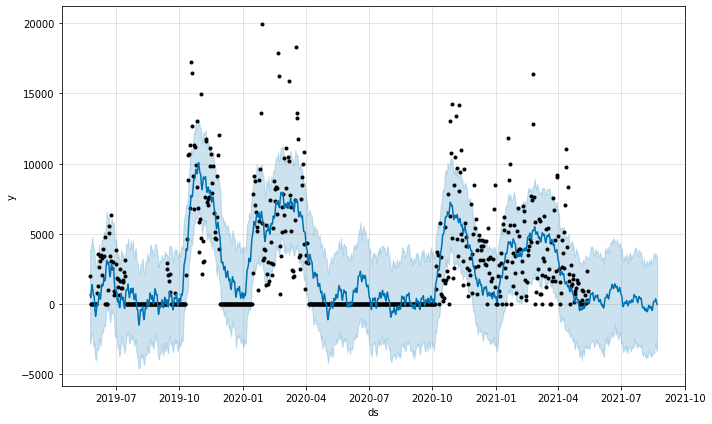

In [ ]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [ ]:
# Python
plot_plotly(prophet, forecast)

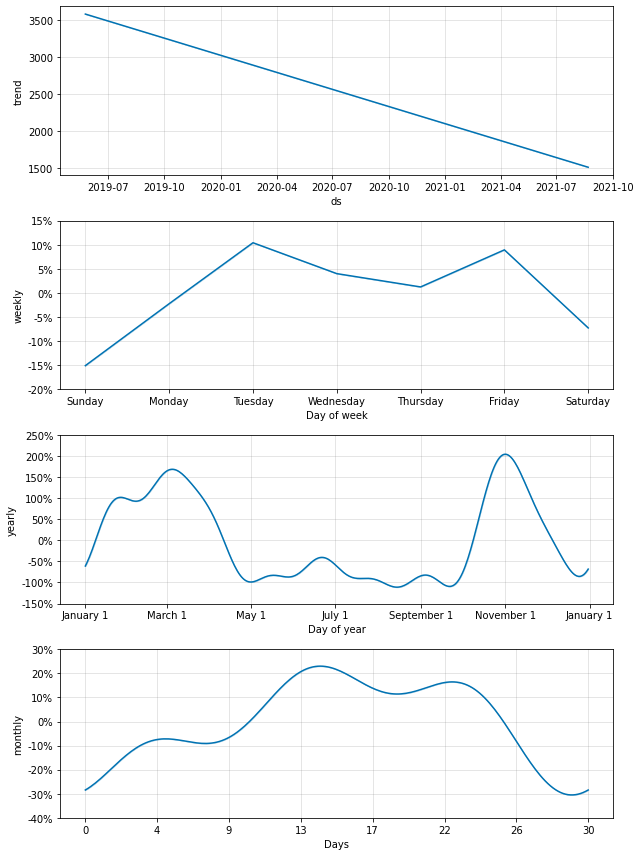

In [ ]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [ ]:
len(forecast)

821

In [ ]:
# use built in fbprophet evaluation function and metrix
evaluation_model = cross_validation(prophet, initial='500 days', period='30 days', horizon = '15 days')

INFO:prophet:Making 7 forecasts with cutoffs between 2020-10-31 00:00:00 and 2021-04-29 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.sort_values('rmse').head(5)

INFO:prophet:Skipping MAPE because y close to 0


horizon           mse         rmse          mae     mdape     smape  \
4  6 days  6.119090e+06  2473.679480  1804.256974  0.664235  0.966592   
5  7 days  7.509215e+06  2740.294627  2011.211971  0.765546  0.950764   
0  2 days  8.549835e+06  2924.010030  2255.946500  0.652908  1.028976   
3  5 days  9.513447e+06  3084.387670  1747.252944  0.691977  0.941526   
1  3 days  1.134176e+07  3367.753527  2477.276322  0.817125  1.084593   

   coverage  
4  0.857143  
5  0.657143  
0  0.671429  
3  0.857143  
1  0.614286

Overall, the model shows a good fit.

# Gold Price Prediction Using Fb Prophet

In [ ]:
# install relevant, necessary packages
!pip install pandas
!pip install numpy
!pip install prophet
!pip install plotnine

In [ ]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [ ]:
# let's load the data to colab and read it as a panda dataframe.
# Load the data file from local disk to Colab env. Run the following command and select the csv file to upload
from google.colab import files
datafile = files.upload()

Saving gold_monthly_csv.csv to gold_monthly_csv.csv


In [ ]:
# Let's convert the datafile into a dataframe
# Put the csv filename as filename
filename = 'gold_monthly_csv.csv'
df = pd.read_csv(filename) # important to specify encoding

In [ ]:
# check total number of cells, first few rows, and descriptive stats 
def descriptive_info(df):
#  number_of_cells = df.count(axis=0, level=None, numeric_only=False)
  # Let's check the shape of the dataset
  print('Features:', df.shape[1], ' ', 'Entries:', df.shape[0])
  print('\n\n')
  print('Printing descriptive statistics...\n\n', df.describe())

In [ ]:
# now check some basic info of our dataset
descriptive_info(df)

Features: 2   Entries: 847



Printing descriptive statistics...

              Price
count   847.000000
mean    416.556906
std     453.665313
min      34.490000
25%      35.190000
50%     319.622000
75%     447.029000
max    1840.807000


In [ ]:
# Let's define a function to check the type of our features and check for 
# missing values in our dataset
def missing_val(df):
  print(df.info())
  print('\n\nFeatures with missing values in descending order \n\n')
  print((df.isnull().sum()/ df.shape[0]).sort_values(ascending=False))

In [ ]:
# Now apply the missing_val function
missing_val(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    847 non-null    object 
 1   Price   847 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.4+ KB
None


Features with missing values in descending order 


Date     0.0
Price    0.0
dtype: float64


In [ ]:
# This Function is to prepare the dataset for Fb Prophet
#ds, save the name of date column as ds
#y, save the name of column we are interested in as y
def prepare_data(df, ds, y):
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
  df = df[[ds, y]]
  df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
  print('The series is ready for use.\n')
  return df

In [ ]:
# Use the function to prepare the dataframe to feed into fbprophet
# df = series, ds = the time variable name from the dataframe (string), 
# y = intended variable name for prediction from the dataframe, (string)
df2 = prepare_data(df, ds = 'Date', y = 'Price') 
print(df2.head())
print('')
print('The length of your series is: ', len(df2))

The series is ready for use.

        ds      y
0  1950-01  34.73
1  1950-02  34.73
2  1950-03  34.73
3  1950-04  34.73
4  1950-05  34.73

The length of your series is:  847


In [ ]:
## function to Plot the prepared data
def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

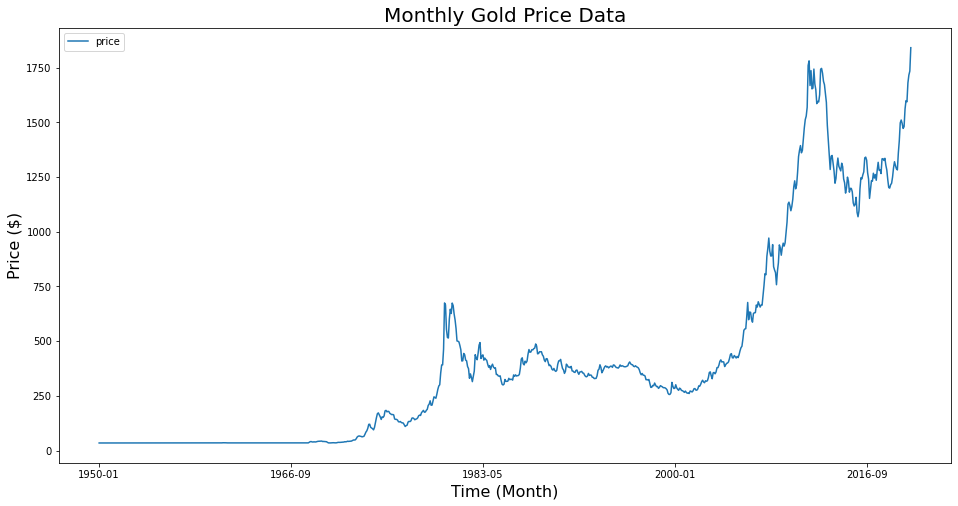

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'ds'
Y = 'y'
Label = "price"
Figsize = (16,8)
Title = "Monthly Gold Price Data"
xAxisLabel = 'Time (Month)'
yAxisLabel = 'Price ($)'
_fig_plot(df2, X, Y)

The plot clearly shows the presence of an upward trend, and some seasonalities. 

In [ ]:
# let's plot a short window to visualize better
shortX = df2[['ds', 'y']].tail(90)
shortX = shortX.rename(columns = {'ds': 'dss', 'y':'yss'}) 
#shortY = df2.loc[shortX]
shortX.head()
#print(len(shortX), len(shortY))

dss       yss
757  2013-02  1630.688
758  2013-03  1591.013
759  2013-04  1485.905
760  2013-05  1416.143
761  2013-06  1342.700

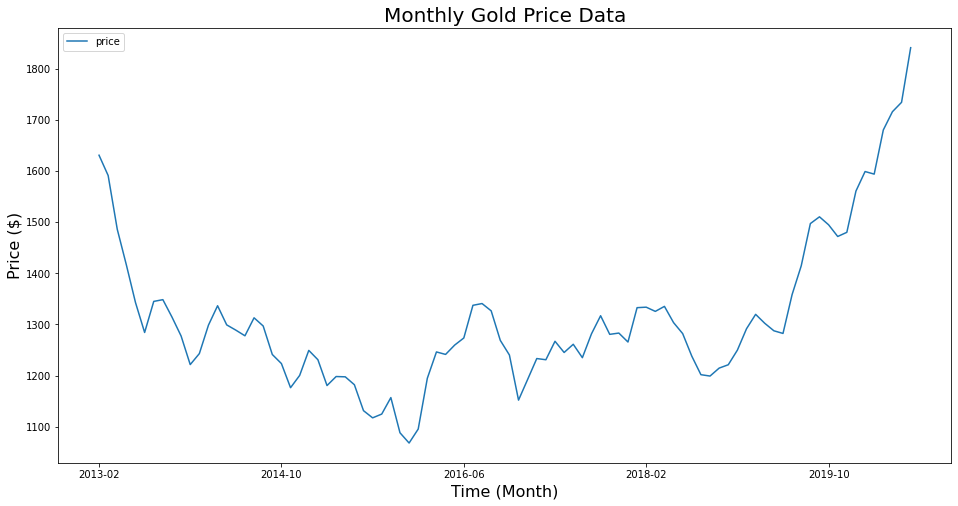

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'dss'
Y = 'yss'
Label = "price"
Figsize = (16,8)
Title = "Monthly Gold Price Data"
xAxisLabel = 'Time (Month)'
yAxisLabel = 'Price ($)'
_fig_plot(shortX, X, Y)

Now, the monthly seasonality is more apparent but no yearly seasonality. Ok, let's use this information when building our model.

In [ ]:
# define training dataset
train = df2.copy()

Available default hyperparameters are-

* growth='linear',
* changepoints=None,
* n_changepoints=25,
* changepoint_range=0.8,
* yearly_seasonality='auto',
* weekly_seasonality='auto',
* daily_seasonality='auto',
* holidays=None,
* seasonality_mode='additive',
* seasonality_prior_scale=10,
* holidays_prior_scale=10,
* changepoint_prior_scale=0.05,
* mcmc_samples=0,
* interval_width=0.8,
* uncertainty_samples=1000,
* stan_backend=None


In [ ]:
# let's predict now
# instantiate the model and fit the timeseries

prophet = Prophet(daily_seasonality= 'auto',
                  weekly_seasonality='auto',
                  yearly_seasonality= False, 
                  growth='linear', 
                  changepoints=None, 
                  n_changepoints=25, 
                  changepoint_range=0.8,  
                  holidays=None, 
                  seasonality_prior_scale=20, 
#                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05, 
                  mcmc_samples=0, 
                  interval_width=0.8, 
                  uncertainty_samples=1000, 
                  stan_backend=None)
prophet.add_seasonality(name='yearly', period=365, fourier_order=3, 
                      mode = 'multiplicative')
prophet.fit(train)


# create a future data frame 
future = prophet.make_future_dataframe(periods=12, freq = 'MS')
forecast = prophet.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Printing outputs from Prophet prediction...
           ds        yhat   yhat_lower   yhat_upper
0 2019-05-25 -613.039385 -4057.568318  3066.768841
1 2019-05-26 -665.920028 -4069.841835  3127.533075
2 2019-05-27 -118.317948 -3601.885280  3414.186080
3 2019-05-28  385.890913 -3025.184634  4093.623094
4 2019-05-29  276.888870 -3124.331412  3757.294440


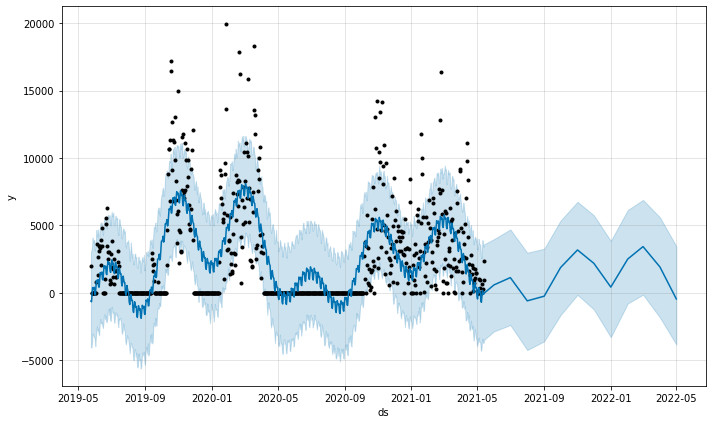

In [ ]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

The plot shows how the model is trying to capture variance in our data.

In [ ]:
# Python
plot_plotly(prophet, forecast)

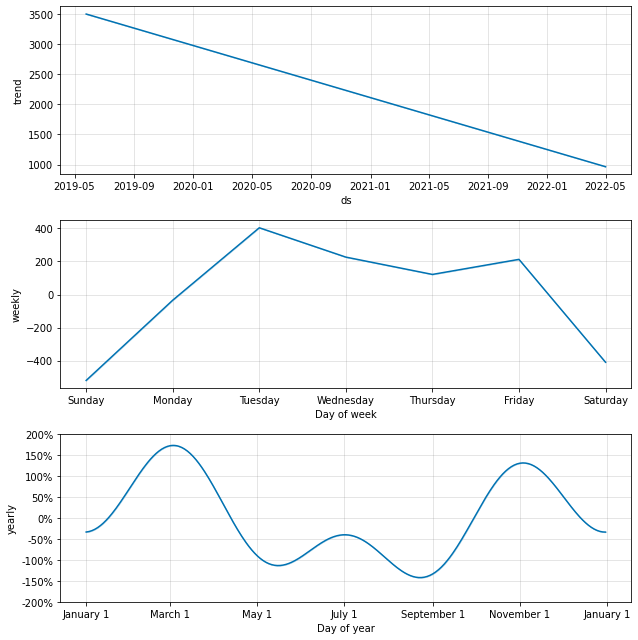

In [ ]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [ ]:
len(df2)

847

In [ ]:
# use built in fbprophet evaluation function and metrix
evaluation_model = cross_validation(prophet, initial='400 days', period='60 days', horizon = '30 days')

INFO:prophet:Making 5 forecasts with cutoffs between 2020-08-17 00:00:00 and 2021-04-14 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.sort_values('rmse').head(5)

INFO:prophet:Skipping MAPE because y close to 0


horizon           mse         rmse          mae     mdape     smape  \
2  5 days  2.985365e+06  1727.820884  1325.164084  0.685865  1.082293   
3  6 days  4.144055e+06  2035.695272  1575.728583  0.704329  1.152152   
6  9 days  4.170580e+06  2042.199866  1425.006638  0.630378  0.993502   
1  4 days  4.251457e+06  2061.906220  1552.059702  0.801133  1.153427   
4  7 days  5.156400e+06  2270.770879  1598.969648  0.527130  0.926119   

   coverage  
2  0.933333  
3  0.866667  
6  0.933333  
1  0.866667  
4  0.866667

By this, we get a moderately good fit to our data.

# Tesla Stock Price prediction Using Fb Prophet

In [ ]:
# install relevant, necessary packages
!pip install pandas
!pip install numpy
!pip install prophet
!pip install plotnine

In [ ]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [ ]:
# let's load the data to colab and read it as a panda dataframe.
# Load the data file from local disk to Colab env. Run the following command and select the csv file to upload
from google.colab import files
datafile = files.upload()

Saving TSLA .csv to TSLA .csv


In [ ]:
# Let's convert the datafile into a dataframe
# Put the csv filename as filename
filename = 'TSLA .csv'
df = pd.read_csv(filename) # important to specify encoding

In [ ]:
# check total number of cells, first few rows, and descriptive stats 
def descriptive_info(df):
#  number_of_cells = df.count(axis=0, level=None, numeric_only=False)
  # Let's check the shape of the dataset
  print('Features:', df.shape[1], ' ', 'Entries:', df.shape[0])
  print('\n\n')
  print('Printing descriptive statistics...\n\n', df.describe())

In [ ]:
# now check some basic info of our dataset
descriptive_info(df)

Features: 7   Entries: 2683



Printing descriptive statistics...

               Open         High          Low        Close    Adj Close  \
count  2683.000000  2683.000000  2683.000000  2683.000000  2683.000000   
mean     70.914358    72.474707    69.285925    71.013916    71.013916   
std     127.180265   130.197125   123.962726   127.525574   127.525574   
min       3.228000     3.326000     2.996000     3.160000     3.160000   
25%       7.592000     7.697000     7.424000     7.578000     7.578000   
50%      44.698002    45.500000    44.049999    44.660000    44.660000   
75%      61.400002    62.524000    60.233999    61.590999    61.590999   
max     891.380005   900.400024   871.599976   883.090027   883.090027   

             Volume  
count  2.683000e+03  
mean   3.177323e+07  
std    2.913656e+07  
min    5.925000e+05  
25%    1.131475e+07  
50%    2.505200e+07  
75%    4.107750e+07  
max    3.046940e+08  


In [ ]:
# Let's define a function to check the type of our features and check for 
# missing values in our dataset
def missing_val(df):
  print(df.info())
  print('\n\nFeatures with missing values in descending order \n\n')
  print((df.isnull().sum()/ df.shape[0]).sort_values(ascending=False))

In [ ]:
# Now apply the missing_val function
missing_val(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2683 entries, 0 to 2682
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2683 non-null   object 
 1   Open       2683 non-null   float64
 2   High       2683 non-null   float64
 3   Low        2683 non-null   float64
 4   Close      2683 non-null   float64
 5   Adj Close  2683 non-null   float64
 6   Volume     2683 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 146.9+ KB
None


Features with missing values in descending order 


Date         0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64


GOOD NEWS! WE HAVE NO MISSING VALUES.

In [ ]:
# This Function is to prepare the dataset for Fb Prophet
#ds, save the name of date column as ds
#y, save the name of column we are interested in as y
def prepare_data(df, ds, y):
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
  df = df[[ds, y]]
  df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
  print('The series is ready for use.\n')
  return df

In [ ]:
# Use the function to prepare the dataframe to feed into fbprophet
# df = series, ds = the time variable name from the dataframe (string), 
# y = intended variable name for prediction from the dataframe, (string)
df2 = prepare_data(df, ds = 'Date', y = 'Adj Close') 
print(df2.head())
print('')
print('The length of your series is: ', len(df2))

The series is ready for use.

           ds      y
0  2010-06-29  4.778
1  2010-06-30  4.766
2  2010-07-01  4.392
3  2010-07-02  3.840
4  2010-07-06  3.222

The length of your series is:  2683


In [ ]:
## function to Plot the prepared data
def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

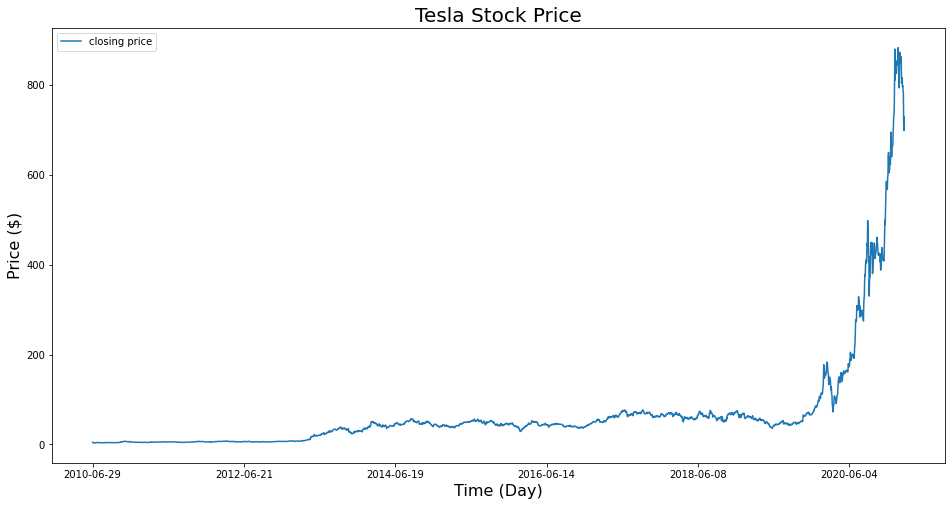

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'ds'
Y = 'y'
Label = "closing price"
Figsize = (16,8)
Title = "Tesla Stock Price"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Price ($)'
_fig_plot(df2, X, Y)

This plot is very interesting. It clearly shows an upward trend overall and after 2018, a sharp pick. Is there any daily or monthly seasonality? There seems like some yearly seasonality. We can keep that in mind.

In [ ]:
shortX = df2[['ds', 'y']].tail(100)
shortX = shortX.rename(columns = {'ds': 'dss', 'y':'yss'}) 
#shortY = df2.loc[shortX]
shortX.head()
#print(len(shortX), len(shortY))

dss         yss
2583  2020-10-01  448.160004
2584  2020-10-02  415.089996
2585  2020-10-05  425.679993
2586  2020-10-06  413.980011
2587  2020-10-07  425.299988

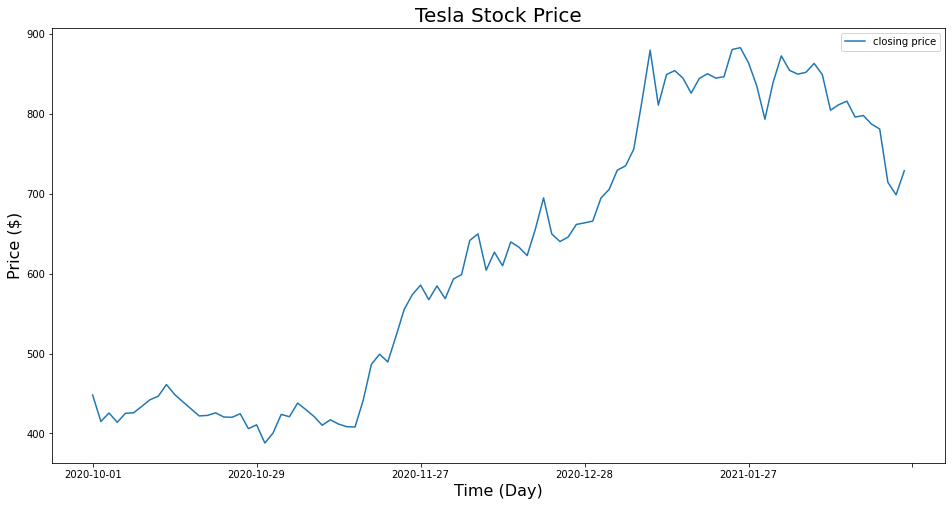

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'dss'
Y = 'yss'
Label = "closing price"
Figsize = (16,8)
Title = "Tesla Stock Price"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Price ($)'
_fig_plot(shortX, X, Y)

Now we can see that at the end of each month the slope goes down. 

In [ ]:
train.tail(1)

Available hyperparameters are-

* growth='linear',
* changepoints=None,
* n_changepoints=25,
* changepoint_range=0.8,
* yearly_seasonality='auto',
* weekly_seasonality='auto',
* daily_seasonality='auto',
* holidays=None,
* seasonality_mode='additive',
* seasonality_prior_scale=10,
* holidays_prior_scale=10,
* changepoint_prior_scale=0.05,
* mcmc_samples=0,
* interval_width=0.8,
* uncertainty_samples=1000,
* stan_backend=None


In [ ]:
# if interested can be used the built in holidays
import holidays 
holiday = pd.DataFrame([])
for date, name in sorted(holidays.US(years=[2019,2020,2021]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [ ]:
holiday.head()

ds      holiday
0 2019-01-01  US-Holidays
1 2019-01-21  US-Holidays
2 2019-02-18  US-Holidays
3 2019-05-27  US-Holidays
4 2019-07-04  US-Holidays

In [ ]:
# let's predict now
# instantiate the model and fit the timeseries

prophet = Prophet(daily_seasonality= 'auto',
                  weekly_seasonality= 'auto',
                  yearly_seasonality= True, 
                  growth='linear', 
                  changepoints=None, 
                  n_changepoints=25, 
                  changepoint_range=0.8,  
                  holidays=holiday, 
                  seasonality_mode='additive', 
                  seasonality_prior_scale=10, 
                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05, 
                  mcmc_samples=0, 
                  interval_width=0.8, 
                  uncertainty_samples=1000, 
                  stan_backend=None)
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=3)
prophet.fit(train)

# create a future data frame 
future = prophet.make_future_dataframe(periods=30)
forecast = prophet.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Printing outputs from Prophet prediction...
           ds         yhat   yhat_lower   yhat_upper
0 2019-05-25   802.331463 -2365.996591  4131.469266
1 2019-05-26   707.171175 -2740.825178  4067.812524
2 2019-05-27  1865.829933 -1669.469921  5239.797399
3 2019-05-28  1595.287386 -1763.766507  5024.374473
4 2019-05-29  1266.662419 -2086.156383  4629.777913


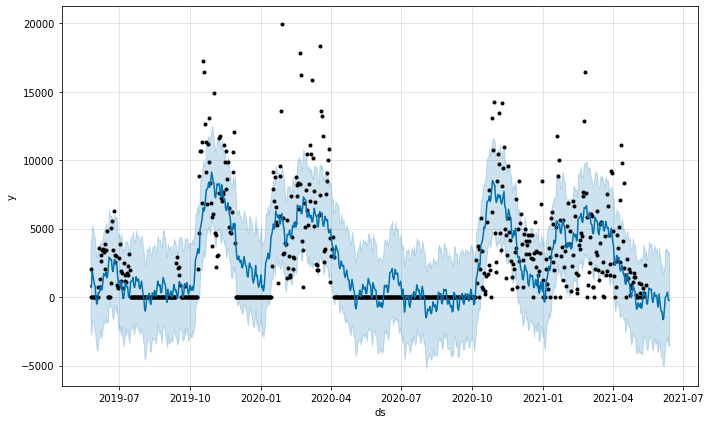

In [ ]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [ ]:
# Python
plot_plotly(prophet, forecast)

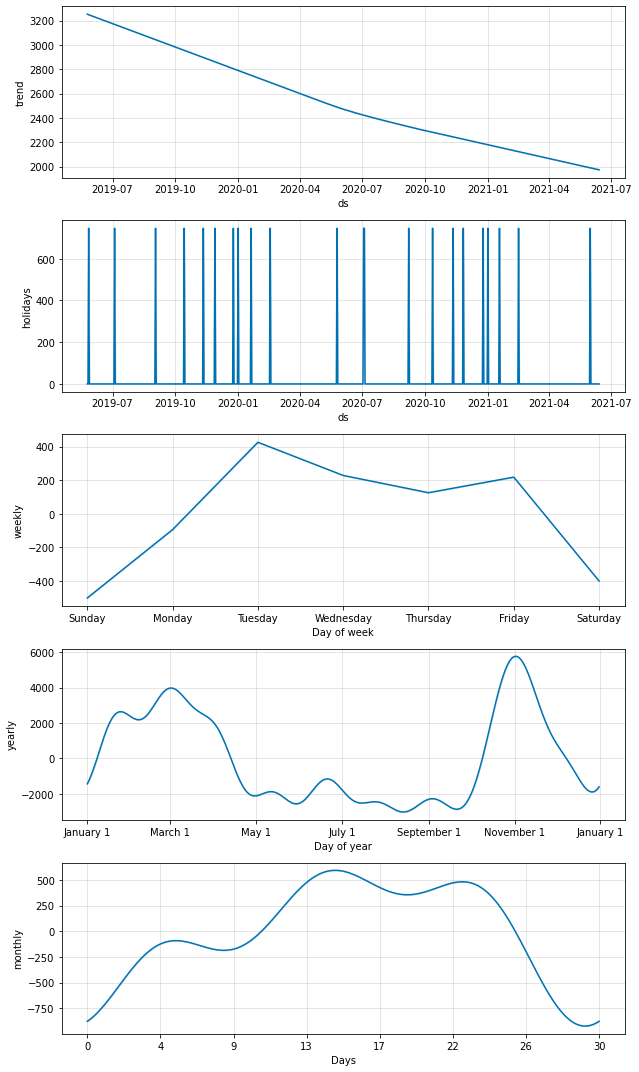

In [ ]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [ ]:
len(train)

721

In [ ]:
# use built in fbprophet evaluation function and metrix
evaluation_model = cross_validation(prophet, initial='400 days', period='60 days', horizon = '30 days')

INFO:prophet:Making 5 forecasts with cutoffs between 2020-08-17 00:00:00 and 2021-04-14 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.sort_values('rmse').head(5)

INFO:prophet:Skipping MAPE because y close to 0


horizon           mse         rmse          mae     mdape     smape  \
24 27 days  7.854830e+06  2802.646951  2285.912380  1.580634  1.293964   
16 19 days  8.229588e+06  2868.725886  2320.859381       inf  1.404504   
2   5 days  8.501586e+06  2915.747924  2105.547514  1.195596  1.335659   
25 28 days  8.531309e+06  2920.840418  2320.011677  2.531124  1.306177   
17 20 days  8.670060e+06  2944.496640  2418.861444       inf  1.390486   

    coverage  
24  0.666667  
16  0.733333  
2   0.800000  
25  0.666667  
17  0.666667

# BitCoin Price Forecasting Using FbProphet

In [ ]:
# install relevant, necessary packages
!pip install pandas
!pip install numpy
!pip install prophet
!pip install plotnine

In [ ]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [ ]:
# let's load the data to colab and read it as a panda dataframe.
# Load the data file from local disk to Colab env. Run the following command and select the csv file to upload
from google.colab import files
datafile = files.upload()

Saving coin_Dogecoin.csv to coin_Dogecoin.csv


In [ ]:
# Let's convert the datafile into a dataframe
# Put the csv filename as filename
filename = 'coin_Dogecoin.csv'
df = pd.read_csv(filename) # important to specify encoding sometimes

In [ ]:
# check total number of cells, first few rows, and descriptive stats 
def descriptive_info(df):
#  number_of_cells = df.count(axis=0, level=None, numeric_only=False)
  # Let's check the shape of the dataset
  print('Features:', df.shape[1], ' ', 'Entries:', df.shape[0])
  print('\n\n')
  print('Printing descriptive statistics...\n\n', df.describe())

In [ ]:
# now check some basic info of our dataset
descriptive_info(df)

Features: 10   Entries: 2760



Printing descriptive statistics...

                SNo         High          Low         Open        Close  \
count  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000   
mean   1380.500000     0.014964     0.012402     0.013669     0.013763   
std     796.887696     0.069103     0.055536     0.062347     0.062559   
min       1.000000     0.000089     0.000085     0.000087     0.000087   
25%     690.750000     0.000231     0.000222     0.000227     0.000226   
50%    1380.500000     0.001914     0.001772     0.001849     0.001844   
75%    2070.250000     0.002986     0.002796     0.002900     0.002899   
max    2760.000000     0.737567     0.608168     0.687801     0.684777   

             Volume     Marketcap  
count  2.760000e+03  2.760000e+03  
mean   4.326321e+08  1.760533e+09  
std    2.807320e+09  8.115186e+09  
min    0.000000e+00  1.509085e+06  
25%    2.536138e+05  2.337892e+07  
50%    5.582480e+06  2.135789e+08  
75%    5.098

Out of all these available prices, we'll be focusing on the closing price as that gives us a better accurate information on trading.

In [ ]:
# Let's define a function to check the type of our features and check for 
# missing values in our dataset
def missing_val(df):
  print(df.info())
  print('\n\nFeatures with missing values in descending order \n\n')
  print((df.isnull().sum()/ df.shape[0]).sort_values(ascending=False))

In [ ]:
# Now apply the missing_val function
missing_val(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760 entries, 0 to 2759
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNo        2760 non-null   int64  
 1   Name       2760 non-null   object 
 2   Symbol     2760 non-null   object 
 3   Date       2760 non-null   object 
 4   High       2760 non-null   float64
 5   Low        2760 non-null   float64
 6   Open       2760 non-null   float64
 7   Close      2760 non-null   float64
 8   Volume     2760 non-null   float64
 9   Marketcap  2760 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 215.8+ KB
None


Features with missing values in descending order 


SNo          0.0
Name         0.0
Symbol       0.0
Date         0.0
High         0.0
Low          0.0
Open         0.0
Close        0.0
Volume       0.0
Marketcap    0.0
dtype: float64


Good news! No missing values.

In [ ]:
df.head() # take a quick pick at our data 

SNo      Name Symbol                 Date      High       Low      Open  \
0    1  Dogecoin   DOGE  2013-12-16 23:59:59  0.000866  0.000150  0.000299   
1    2  Dogecoin   DOGE  2013-12-17 23:59:59  0.000289  0.000116  0.000207   
2    3  Dogecoin   DOGE  2013-12-18 23:59:59  0.000362  0.000205  0.000267   
3    4  Dogecoin   DOGE  2013-12-19 23:59:59  0.001520  0.000328  0.000395   
4    5  Dogecoin   DOGE  2013-12-20 23:59:59  0.001143  0.000662  0.001143   

      Close  Volume     Marketcap  
0  0.000205     0.0  1.509085e+06  
1  0.000269     0.0  2.169688e+06  
2  0.000362     0.0  3.188943e+06  
3  0.001162     0.0  1.115034e+07  
4  0.000704     0.0  7.284337e+06

In [ ]:
# This Function is to prepare the dataset for Fb Prophet
#ds, save the name of date column as ds
#y, save the name of column we are interested in as y
def prepare_data(df, ds, y):
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
  df = df[[ds, y]]
  df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
  df['ds'] = pd.to_datetime(df.ds)
  df['ds'] = df['ds'].dt.date
  print('The series is ready for use.\n')
  return df

In [ ]:
# Use the function to prepare the dataframe to feed into fbprophet
# df = series, ds = the time variable name from the dataframe (string), 
# y = intended variable name for prediction from the dataframe, (string)
df2 = prepare_data(df, ds = 'Date', y = 'Close') 
print(df2.head())
print('')
print('The length of your series is: ', len(df2))

The series is ready for use.

           ds         y
0  2013-12-16  0.000205
1  2013-12-17  0.000269
2  2013-12-18  0.000362
3  2013-12-19  0.001162
4  2013-12-20  0.000704

The length of your series is:  2760


In [ ]:
# Quick look at how the price changes over time
import plotly.express as px
px.area(df2, x='ds', y='y', width=800, height=400)

Very interesting, we see that the price for dodgecoin rose up suddenly in 2021. 

In [ ]:
## function to Plot the prepared data
def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

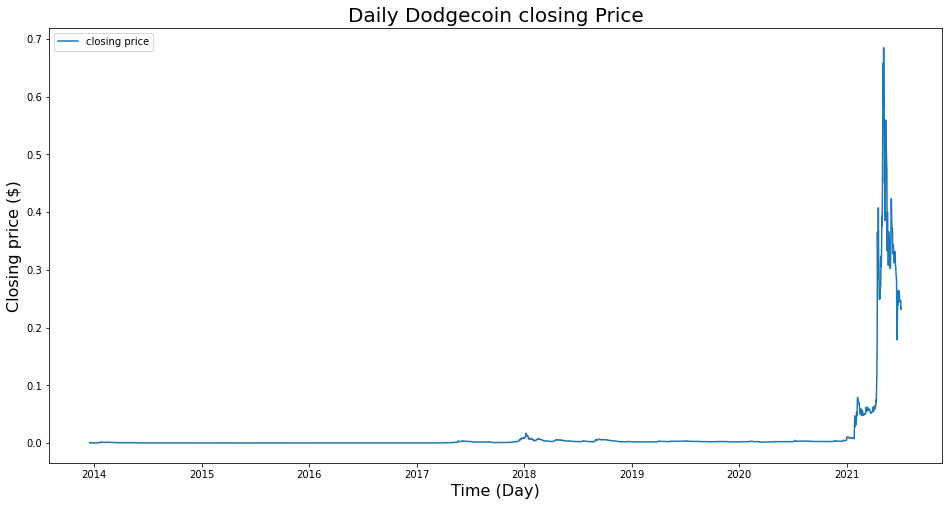

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'ds'
Y = 'y'
Label = "closing price"
Figsize = (16,8)
Title = "Daily Dodgecoin closing Price"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Closing price ($)'
_fig_plot(df2, X, Y)

We see that the series does not truly have any yearly or even monthly seasonality, To check for daily seasonality, let's check the last half-year of the series. Obviously, there is an upward trend present here.

In [ ]:
shortX = df2[['ds', 'y']].tail(180)
shortX = shortX.rename(columns = {'ds': 'dss', 'y':'yss'}) 
#shortY = df2.loc[shortX]
shortX.head()
#print(len(shortX), len(shortY))

dss       yss
2580  2021-01-08  0.009846
2581  2021-01-09  0.010194
2582  2021-01-10  0.009860
2583  2021-01-11  0.008835
2584  2021-01-12  0.008063

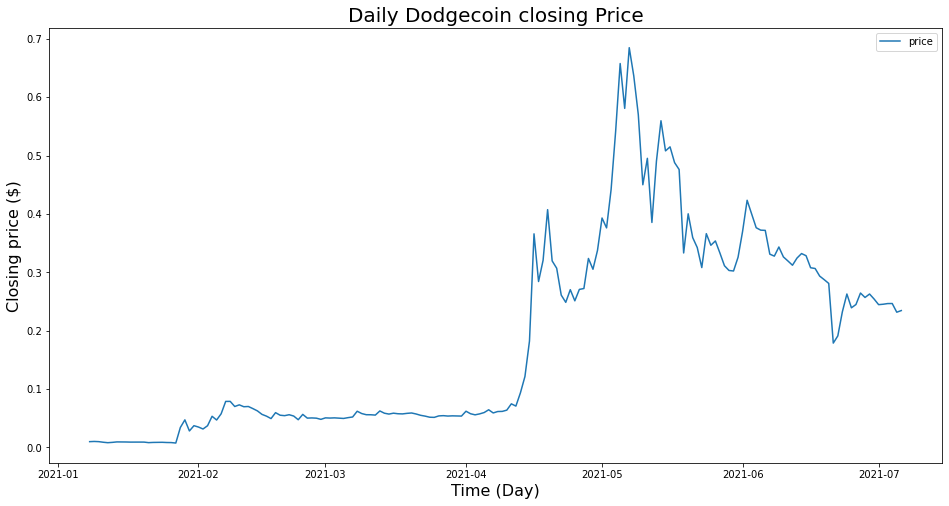

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'dss'
Y = 'yss'
Label = "price"
Figsize = (16,8)
Title = "Daily Dodgecoin closing Price"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Closing price ($)'
_fig_plot(shortX, X, Y)

There seems like some daily and most likely some monthly seasonalities are happening here. let's keep that in mind and use this information when fitting our model with fbprophet.

In [ ]:
# define training dataset
train = df2.copy()

Available hyperparameters are-

* growth='linear',
* changepoints=None,
* n_changepoints=25,
* changepoint_range=0.8,
* yearly_seasonality='auto',
* weekly_seasonality='auto',
* daily_seasonality='auto',
* holidays=None,
* seasonality_mode='additive',
* seasonality_prior_scale=10,
* holidays_prior_scale=10,
* changepoint_prior_scale=0.05,
* mcmc_samples=0,
* interval_width=0.8,
* uncertainty_samples=1000,
* stan_backend=None


Let's include holidays information to be put into our model. Because the series is on the US market, we'll use US holidays only.

In [ ]:
# check out the first and last date to make sure holidays from which years we should include 
first = df2['ds'].head(1)
last = df2['ds'].tail(1)
print(first,'\n\n', last)

0    2013-12-16
Name: ds, dtype: object 

 2759    2021-07-06
Name: ds, dtype: object


In [ ]:
# if required can be used to input as holidays
import holidays 
holiday = pd.DataFrame([])
for date, name in sorted(holidays.US(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [ ]:
# let's predict now
# instantiate the model and fit the timeseries
# in this case, the built in model works better than tuning manually
prophet = Prophet()
#prophet.add_seasonality(name='monthly', period=30.5, fourier_order=3)

prophet.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# create a future data frame  and make forecasting
future = prophet.make_future_dataframe(periods=100)
forecast = prophet.predict(future)

Printing outputs from Prophet prediction...
           ds      yhat  yhat_lower  yhat_upper
0 2013-12-16 -0.008235   -0.061213    0.048138
1 2013-12-17 -0.008003   -0.068494    0.047376
2 2013-12-18 -0.008061   -0.068813    0.044545
3 2013-12-19 -0.007777   -0.065779    0.049746
4 2013-12-20 -0.007107   -0.062149    0.049151


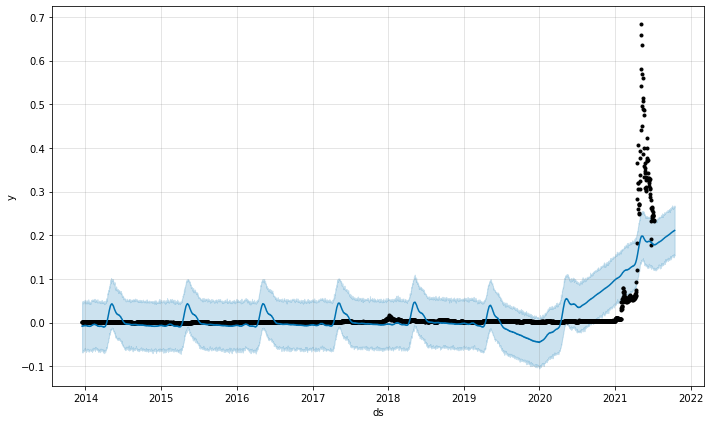

In [ ]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [ ]:
# Use the plot_plotly function to visualize prediction as seperate window size
plot_plotly(prophet, forecast)

The model captured the upward trend of our series and the downward movement as well. The prediction is that the price is most likely won't go that up for next two months.

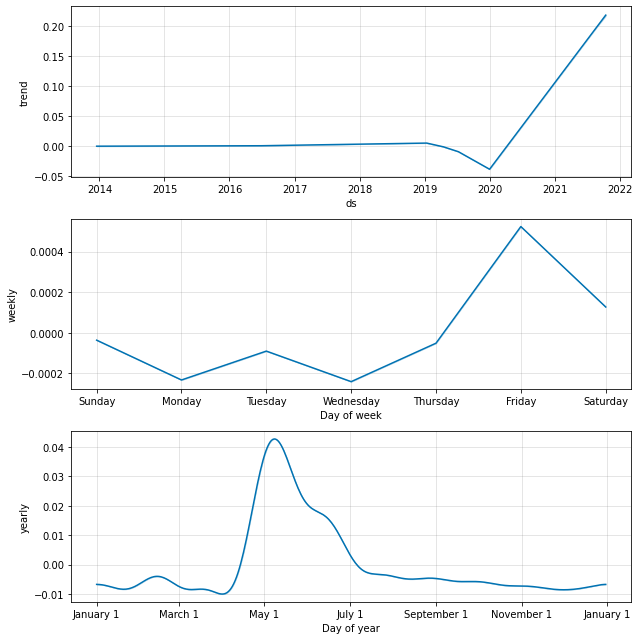

In [ ]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [ ]:
# use built in fbprophet evaluation function and metrix
evaluation_model = cross_validation(prophet, initial='800 days', period='50 days', horizon = '25 days')

INFO:prophet:Making 39 forecasts with cutoffs between 2016-03-29 00:00:00 and 2021-06-11 00:00:00


  0%|          | 0/39 [00:00<?, ?it/s]

In [ ]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.sort_values('rmse').head(5) # sorted the output based on 'rmse'

horizon       mse      rmse       mae      mape     mdape     smape  \
0  3 days  0.001807  0.042512  0.011232  0.348850  0.264661  0.389045   
1  4 days  0.001905  0.043645  0.011524  0.359935  0.271426  0.398247   
2  5 days  0.001914  0.043752  0.011622  0.371959  0.280270  0.410256   
3  6 days  0.002167  0.046553  0.012156  0.384028  0.295407  0.421129   
4  7 days  0.002270  0.047649  0.012285  0.391606  0.311903  0.425283   

   coverage  
0  0.594766  
1  0.615649  
2  0.636003  
3  0.641026  
4  0.620407

#  

# Real Extate Prediction Using FbProphet

In [ ]:
# install relevant, necessary packages
!pip install pandas
!pip install numpy
!pip install prophet
!pip install plotnine

In [ ]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [ ]:
# let's load the data to colab and read it as a panda dataframe.
# Load the data file from local disk to Colab env. Run the following command and select the csv file to upload
from google.colab import files
datafile = files.upload()

Saving State_time_series.csv to State_time_series.csv


In [ ]:
# Let's convert the datafile into a dataframe
# Put the csv filename as filename
filename = 'State_time_series.csv'
df = pd.read_csv(filename) # important to specify encoding

In [ ]:
# check total number of cells, first few rows, and descriptive stats 
def descriptive_info(df):
#  number_of_cells = df.count(axis=0, level=None, numeric_only=False)
  # Let's check the shape of the dataset
  print('Features:', df.shape[1], ' ', 'Entries:', df.shape[0])
  print('\n\n')
  print('Printing descriptive statistics...\n\n', df.describe())

In [ ]:
# now check some basic info of our dataset
descriptive_info(df)

Features: 82   Entries: 13212



Printing descriptive statistics...

        DaysOnZillow_AllHomes  InventorySeasonallyAdjusted_AllHomes  \
count            4845.000000                           4896.000000   
mean              110.117363                          33292.662786   
std                27.474195                          34926.704422   
min                49.250000                            972.000000   
25%                90.250000                           9828.500000   
50%               108.500000                          21712.500000   
75%               126.750000                          47453.000000   
max               251.625000                         260687.000000   

       InventoryRaw_AllHomes  MedianListingPricePerSqft_1Bedroom  \
count            4896.000000                         3586.000000   
mean            33299.013685                          182.470536   
std             35014.163714                           99.809488   
min               911.00000

In [ ]:
# Let's define a function to check the type of our features and check for 
# missing values in our dataset
def missing_val(df):
  print(df.info())
  print('\n\nFeatures with missing values in descending order \n\n')
  print((df.isnull().sum()/ df.shape[0]).sort_values(ascending=False))

In [ ]:
# Now apply the missing_val function
missing_val(df)

In [ ]:
States_Prices=df.groupby([df.Date, df.RegionName])['ZHVI_AllHomes'].mean().dropna().reset_index(name='SoldPrice')

In [ ]:
# getting rid of columns that we are not going to use for this project
df2 = df[['Date', 'RegionName', 'ZHVI_AllHomes']]
df2.head()

Date  RegionName  ZHVI_AllHomes
0  1996-04-30     Alabama        79500.0
1  1996-04-30     Arizona       103600.0
2  1996-04-30    Arkansas        64400.0
3  1996-04-30  California       157900.0
4  1996-04-30    Colorado       128100.0

In [ ]:
# Let's check which state has maximum data in our data set
a = df2.groupby('RegionName').size().sort_values(ascending=False)
print(a)

In [ ]:
# let's look at the data from california. But you can select any other state as well

df_cal = df2[df2['RegionName'] == 'California']

Now, we are on the correct track and can use this for feeding into fbprophet.

In [ ]:
df_cal.head()

Date  RegionName  ZHVI_AllHomes
3    1996-04-30  California       157900.0
47   1996-05-31  California       157800.0
93   1996-06-30  California       157500.0
139  1996-07-31  California       157300.0
185  1996-08-31  California       157000.0

In [ ]:
# This Function is to prepare the dataset for Fb Prophet
#ds, save the name of date column as ds
#y, save the name of column we are interested in as y
def prepare_data(df, ds, y):
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
  df = df[[ds, y]]
  df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
  print('The series is ready for use.\n')
  return df

In [ ]:
# Use the function to prepare the dataframe to feed into fbprophet
# df = series, ds = the time variable name from the dataframe (string), 
# y = intended variable name for prediction from the dataframe, (string)
df3 = prepare_data(df_cal, ds = 'Date', y = 'ZHVI_AllHomes') 
print(df3.head())
print('')
print('The length of your series is: ', len(df3))

The series is ready for use.

             ds         y
3    1996-04-30  157900.0
47   1996-05-31  157800.0
93   1996-06-30  157500.0
139  1996-07-31  157300.0
185  1996-08-31  157000.0

The length of your series is:  261


In [ ]:
# Quick look at how the price changes over time
import plotly.express as px
px.area(df3, x='ds', y='y', width=800, height=400)

In [ ]:
## function to Plot the prepared data
def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

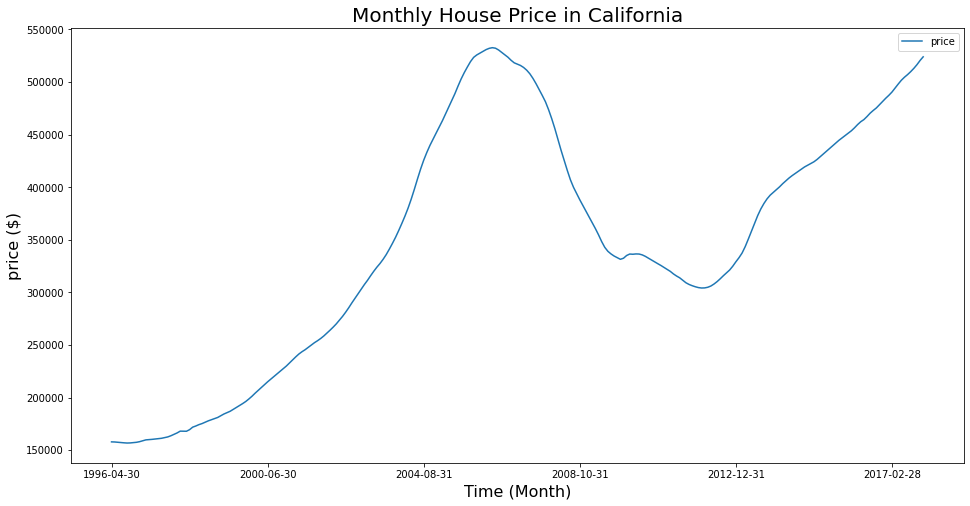

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'ds'
Y = 'y'
Label = "price"
Figsize = (16,8)
Title = "Monthly House Price in California"
xAxisLabel = 'Time (Month)'
yAxisLabel = 'price ($)'
_fig_plot(df3, X, Y)

Both plots clearly show an overall upward trend but there does not seem to be a daily or monthly or even yearly seasonalities. In such case, fbprophet default model works just fine. Let's fit in our model and predict.

We need to remember than this is a monthly data.

In [ ]:
shortX = df3[['ds', 'y']].tail(36) # keeping last three years of data
shortX = shortX.rename(columns = {'ds': 'dss', 'y':'yss'}) 
#shortY = df2.loc[shortX]
shortX.head()
#print(len(shortX), len(shortY))


dss       yss
11345  2015-01-31  424200.0
11397  2015-02-28  426400.0
11449  2015-03-31  429000.0
11501  2015-04-30  431700.0
11553  2015-05-31  434300.0

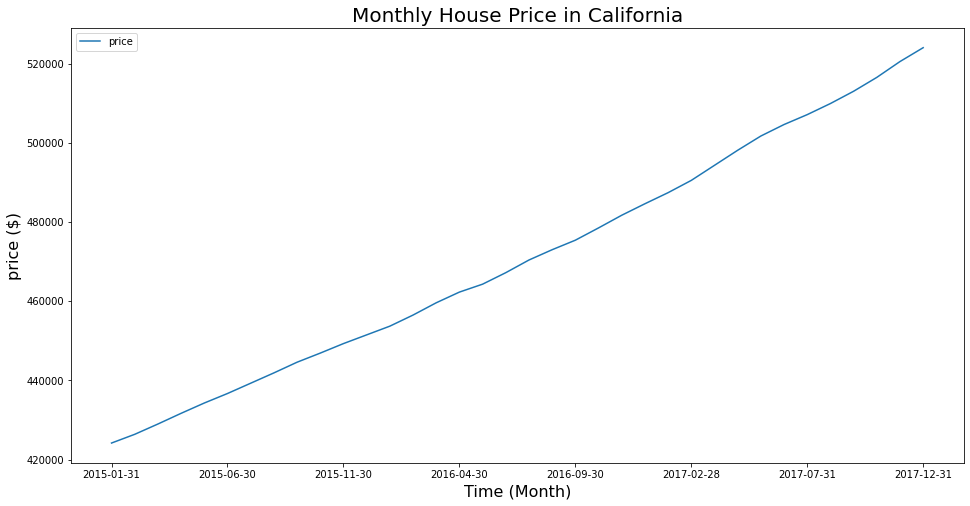

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'dss'
Y = 'yss'
Label = "price"
Figsize = (16,8)
Title = "Monthly House Price in California"
xAxisLabel = 'Time (Month)'
yAxisLabel = 'price ($)'
_fig_plot(shortX, X, Y)

As we discussed before, only an upward trend, no seasonality or cyclic behavior. Let's continue

In [ ]:
# define training dataset
train = df3.copy()
train.tail(1)

ds         y
13165  2017-12-31  524000.0

Available hyperparameters are-

* growth='linear',
* changepoints=None,
* n_changepoints=25,
* changepoint_range=0.8,
* yearly_seasonality='auto',
* weekly_seasonality='auto',
* daily_seasonality='auto',
* holidays=None,
* seasonality_mode='additive',
* seasonality_prior_scale=10,
* holidays_prior_scale=10,
* changepoint_prior_scale=0.05,
* mcmc_samples=0,
* interval_width=0.8,
* uncertainty_samples=1000,
* stan_backend=None

In [ ]:
# let's predict now
# instantiate the model and fit the timeseries

prophet = Prophet()
prophet.fit(train)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# create a future data frame 
future = prophet.make_future_dataframe(periods=48, freq= 'MS')
forecast = prophet.predict(future)

Printing outputs from Prophet prediction...
           ds           yhat     yhat_lower     yhat_upper
0 1996-04-30  154958.023432  151560.895592  158453.805477
1 1996-05-31  155458.564520  152093.277913  159253.118715
2 1996-06-30  155787.703372  152092.023657  159075.719233
3 1996-07-31  156177.065719  152509.558351  159690.438296
4 1996-08-31  156830.871368  153290.893316  160292.573897


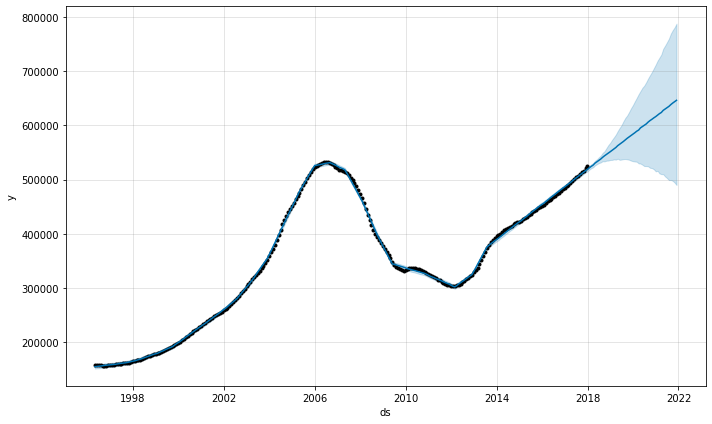

In [ ]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [ ]:
# Use the plot_plotly function to visualize prediction as seperate window size
plot_plotly(prophet, forecast)

The model fits the data well and shows that the price is overall going to go up for next 3 years. But as we move forwrd, the uncertainity increases around the prediction.

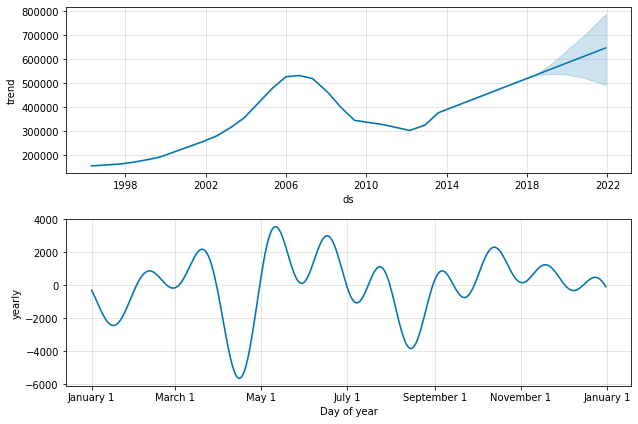

In [ ]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [ ]:
firstdate = train['ds'].iloc[0]
lastdate = train['ds'].iloc[-1]
print('First and last date in your date column are: ', firstdate, lastdate)

First and last date in your date column are:  1996-04-30 2017-12-31


In [ ]:
cutoffs = pd.date_range(start='2000-01-01', end='2005-01-01', freq='4MS') # will make quarterly prediction
print(cutoffs)

DatetimeIndex(['2000-01-01', '2000-05-01', '2000-09-01', '2001-01-01',
               '2001-05-01', '2001-09-01', '2002-01-01', '2002-05-01',
               '2002-09-01', '2003-01-01', '2003-05-01', '2003-09-01',
               '2004-01-01', '2004-05-01', '2004-09-01', '2005-01-01'],
              dtype='datetime64[ns]', freq='4MS')


In [ ]:
# Let's use the built in fbprophet evaluation function and metrix
evaluation_model = cross_validation(prophet, horizon = '120 days', cutoffs=cutoffs)

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.sort_values('rmse').head(5)

horizon           mse         rmse          mae      mape     mdape  \
2  58 days  2.246563e+07  4739.792154  3312.266715  0.009473  0.006942   
3  59 days  2.538806e+07  5038.656997  3663.729318  0.010376  0.010270   
1  30 days  3.070253e+07  5540.986615  3548.930622  0.010200  0.006295   
5  89 days  3.547570e+07  5956.147797  3932.299527  0.011285  0.003863   
8 119 days  4.747996e+07  6890.570014  4218.823590  0.012200  0.006811   

      smape  coverage  
2  0.009568  0.236364  
3  0.010478  0.150000  
1  0.010313  0.181818  
5  0.011423  0.620000  
8  0.012384  0.600000

Overall, The model is not a perfect fit. But it gives us insights of the market. It shows that the house price in California is going to increase for next 4 months in the future. 

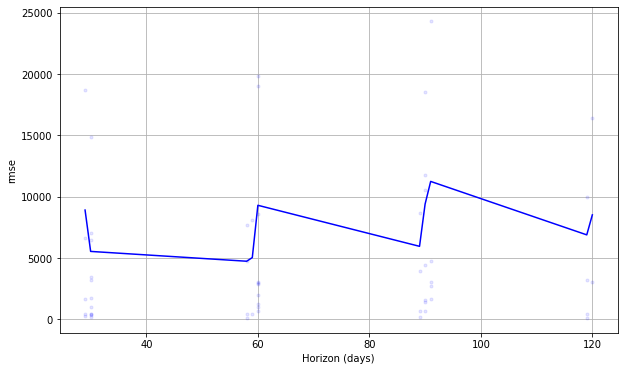

In [ ]:
# If you would like to visualize the cross validation, use the following command
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(evaluation_model, metric='rmse')


# Dengue Forecasting using FbProphet

Metadata for Dengue in Iquito, Peru - 2000/2001 to 2008/2009 Seasons

The dataset contains weekly dengue data for the city of Iquitos, Peru. The dataset includes the following variables:

* season: the transmission season;
* season_week: week of the season (not the calendar year - the season starts following the week with historically lowest dengue cases over the years 2000-2009);
* week_start_date: date of the first day of the week;
* denv1_cases: number of laboratory confirmed cases with DENV1;
* denv2_cases: number of laboratory confirmed cases with DENV2;
* denv3_cases: number of laboratory confirmed cases with DENV3;
* denv4_cases: number of laboratory confirmed cases with DENV4;
* other_positive_cases: laboratory-positive cases without serotype identified (these include acute IgM positive and IgM conversions);
* additional_cases: at times not all specimens submitted were tested due to overload of the capacity for testing or incomplete case information. For those weeks, the number of additional laboratory-positive cases among those not tested was estimated by multiplying the number of untested cases by the rate of laboratory-positive cases amongst those that were tested;
* total_cases: the sum of all cases (denv1-4_cases + additional_cases), the target time series for forecasting.

In [ ]:
!pip install requests
# install relevant, necessary packages
!pip install pandas
!pip install numpy
!pip install prophet
!pip install plotnine

In [ ]:
# import necessary libraries
import requests
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [ ]:
# let's load the data to colab and read it as a panda dataframe.
# Load the data file from local disk to Colab env. Run the following command and select the csv file to upload
from google.colab import files
datafile = files.upload()

Saving dengue_data.csv to dengue_data.csv


In [ ]:
# Let's convert the datafile into a dataframe
# Put the csv filename as filename
filename = 'dengue_data.csv'
df = pd.read_csv(filename) # important to specify encoding

In [ ]:
# check total number of cells, first few rows, and descriptive stats 
def descriptive_info(df):
#  number_of_cells = df.count(axis=0, level=None, numeric_only=False)
  # Let's check the shape of the dataset
  print('Features:', df.shape[1], ' ', 'Entries:', df.shape[0])
  print('\n\n')
  print('Printing descriptive statistics...\n\n', df.describe())

In [ ]:
# now check some basic info of our dataset
descriptive_info(df)

Features: 9   Entries: 468



Printing descriptive statistics...

        season_week  denv1_cases  denv2_cases  denv3_cases  denv4_cases  \
count   468.000000   468.000000   468.000000   468.000000   468.000000   
mean     26.500000     0.141026     0.019231     4.183761     1.085470   
std      15.024391     0.747146     0.152263     6.931633     4.787694   
min       1.000000     0.000000     0.000000     0.000000     0.000000   
25%      13.750000     0.000000     0.000000     0.000000     0.000000   
50%      26.500000     0.000000     0.000000     2.000000     0.000000   
75%      39.250000     0.000000     0.000000     5.000000     0.000000   
max      52.000000     8.000000     2.000000    54.000000    43.000000   

       other_positive_cases  total_cases  
count            468.000000   468.000000  
mean               2.344017     7.773504  
std                4.208082    11.209891  
min                0.000000     0.000000  
25%                0.750000     1.000000  
50%     

In [ ]:
# Let's define a function to check the type of our features and check for 
# missing values in our dataset
def missing_val(df):
  print(df.info())
  print('\n\nFeatures with missing values in descending order \n\n')
  print((df.isnull().sum()/ df.shape[0]).sort_values(ascending=False))

In [ ]:
# Now apply the missing_val function
missing_val(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   season                468 non-null    object
 1   season_week           468 non-null    int64 
 2   week_start_date       468 non-null    object
 3   denv1_cases           468 non-null    int64 
 4   denv2_cases           468 non-null    int64 
 5   denv3_cases           468 non-null    int64 
 6   denv4_cases           468 non-null    int64 
 7   other_positive_cases  468 non-null    int64 
 8   total_cases           468 non-null    int64 
dtypes: int64(7), object(2)
memory usage: 33.0+ KB
None


Features with missing values in descending order 


season                  0.0
season_week             0.0
week_start_date         0.0
denv1_cases             0.0
denv2_cases             0.0
denv3_cases             0.0
denv4_cases             0.0
other_positive_cases    0.0
total_cases 

Wonderful! We don't have any missing values. Let's continue. For prediction, we'll use the total cases variable and notice that this is a weekly dataset.

In [ ]:
# This Function is to prepare the dataset for Fb Prophet
#ds, save the name of date column as ds
#y, save the name of column we are interested in as y
def prepare_data(df, ds, y):
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
  df = df[[ds, y]]
  df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
  print('The series is ready for use.\n')
  return df

In [ ]:
# Use the function to prepare the dataframe to feed into fbprophet
# df = series, ds = the time variable name from the dataframe (string), 
# y = intended variable name for prediction from the dataframe, (string)
df2 = prepare_data(df, ds = 'week_start_date', y = 'total_cases') 
print(df2.head())
print('')
print('The length of your series is: ', len(df2))

The series is ready for use.

           ds  y
0  2000-07-01  0
1  2000-07-08  0
2  2000-07-15  0
3  2000-07-22  0
4  2000-07-29  0

The length of your series is:  468


In [ ]:
## function to Plot the prepared data
def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

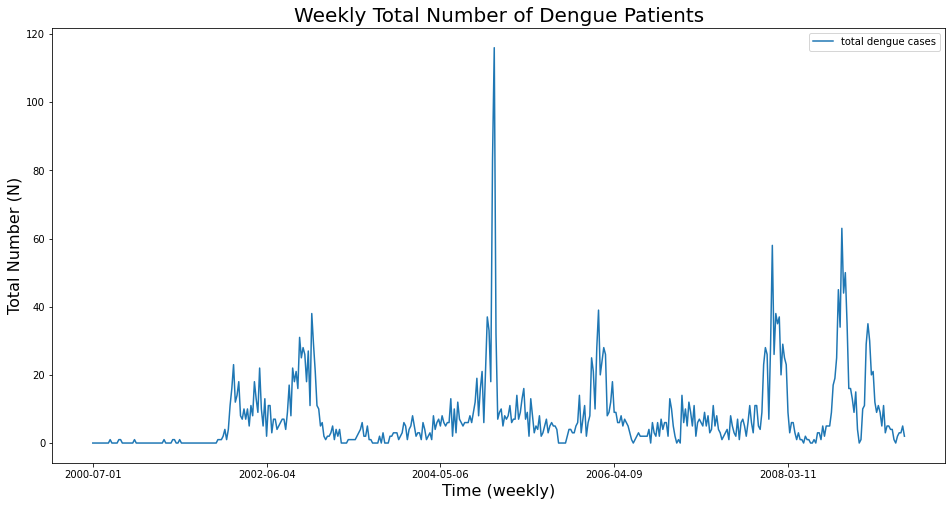

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'ds'
Y = 'y'
Label = "total dengue cases"
Figsize = (16,8)
Title = "Weekly Total Number of Dengue Patients"
xAxisLabel = 'Time (weekly)'
yAxisLabel = 'Total Number (N)'
_fig_plot(df2, X, Y)

In [ ]:
# Quick look at how the price changes over time
import plotly.express as px
px.area(df2, x='ds', y='y', width=800, height=400)

There might be a week upward thrend here. But yearly and monthly seasonality can be there. The one input around 2005 seems like an outlier. We'll handle this next.

In [ ]:
cols = ['y'] # one or more

Q1 = df2[cols].quantile(0.05)
Q3 = df2[cols].quantile(0.95)
IQR = Q3 - Q1

df2 = df2[~((df2[cols] < (Q1 - 1.5 * IQR)) |(df2[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
df2.head(5)

ds  y
0  2000-07-01  0
1  2000-07-08  0
2  2000-07-15  0
3  2000-07-22  0
4  2000-07-29  0

In [ ]:
# Quick look at how the price changes over time
import plotly.express as px
px.area(df2, x='ds', y='y', width=800, height=400)

Very good! So, we got rid of the outliers now. Let's continue to do our prediction. 

In [ ]:
shortX = df2[['ds', 'y']].tail(73)
shortX = shortX.rename(columns = {'ds': 'dss', 'y':'yss'}) 
#shortY = df2.loc[shortX]
shortX.head()
#print(len(shortX), len(shortY))

dss  yss
395  2008-02-05   37
396  2008-02-12   20
397  2008-02-19   29
398  2008-02-26   25
399  2008-03-04   23

In [ ]:
# provide variable names and other required inputs to plot using the function
import plotly.express as px
px.area(shortX, x='dss', y='yss', width=800, height=400)

In [ ]:
# define training dataset
train = df2.copy()

In [ ]:
# let's predict now
# instantiate the model and fit the timeseries

prophet = Prophet(daily_seasonality= False,
                  weekly_seasonality= True,
                  yearly_seasonality= True, 
                  growth='linear', 
                  changepoints=None, 
                  n_changepoints=25, 
                  changepoint_range=0.8,  
                  holidays=None, 
                  seasonality_mode='multiplicative', 
                  seasonality_prior_scale=10, 
                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05, 
                  mcmc_samples=0, 
                  interval_width=0.8, 
                  uncertainty_samples=1000, 
                  stan_backend=None)
prophet.fit(train)


In [ ]:
# create a future data frame 
future = prophet.make_future_dataframe(periods=52, freq='W')
forecast = prophet.predict(future)

Printing outputs from Prophet prediction...
           ds      yhat  yhat_lower  yhat_upper
0 2000-07-01  0.030242   -9.323499    8.681868
1 2000-07-08  0.104131   -8.837323    9.104359
2 2000-07-15  0.203857   -8.886707    9.201469
3 2000-07-22  0.241902   -8.346585    9.438868
4 2000-07-29  0.191173   -8.503774    8.942790


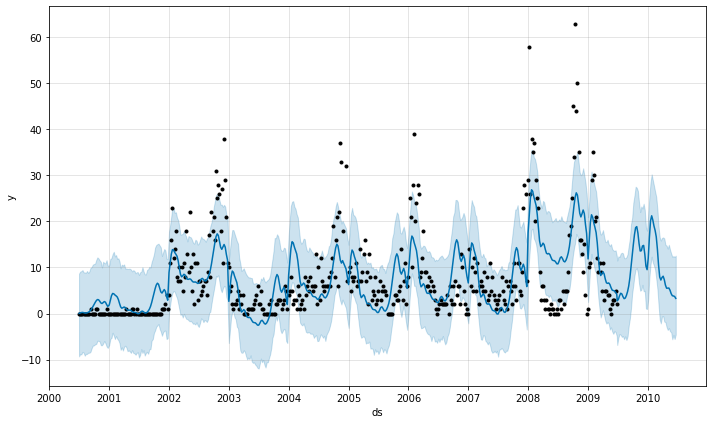

In [ ]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [ ]:
# Python
plot_plotly(prophet, forecast)

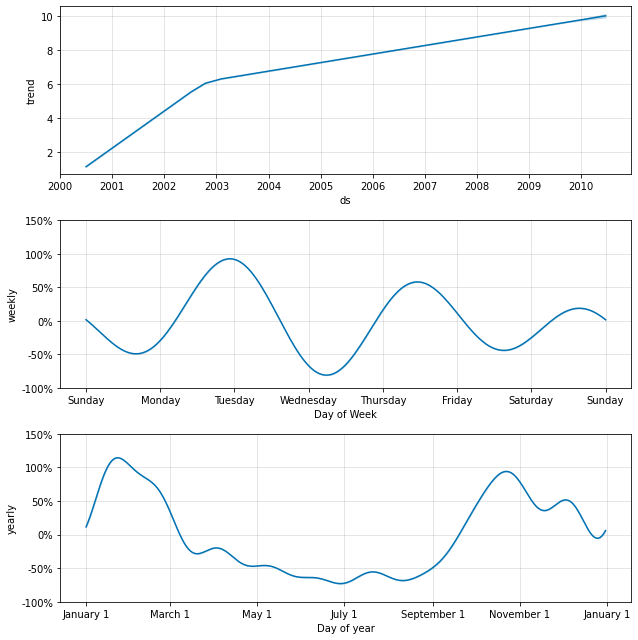

In [ ]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [ ]:
# use built in fbprophet evaluation function and metrix
evaluation_model = cross_validation(prophet, initial='300 days', period='49 days', horizon = '2 W')

INFO:prophet:Making 61 forecasts with cutoffs between 2001-05-24 00:00:00 and 2009-06-11 00:00:00


  0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.sort_values('rmse').head(5)

INFO:prophet:Skipping MAPE because y close to 0


horizon        mse      rmse       mae     mdape     smape  coverage
1  4 days  15.507499  3.937956  2.961343  1.288391  1.300541  0.538462
7 11 days  16.775075  4.095739  3.375561  1.590320  1.504372  0.583333
4  7 days  28.083961  5.299430  4.247821  0.717324  0.790141  0.687500
5  9 days  50.642067  7.116324  5.290438  0.717324  0.700715  0.659091
6 10 days  52.890434  7.272581  5.888497  0.425161  0.655249  0.593750

The RMSE and other error values indicate a goof fit to data and prediction accuracy.

# Store visitors prediction

In [ ]:
# install relevant, necessary packages
!pip install pandas
!pip install numpy
!pip install prophet
!pip install plotnine

In [ ]:
# import more necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
#import pandas_datareader.data as web
import matplotlib.pyplot as plt
#import seaborn as sns
#import matplotlib.dates as mdates
import pandas as pd
#from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error
import holidays

In [ ]:
# Load the data file from local disk to Colab env. Run the following command and select the csv file to upload
from google.colab import files
datafile = files.upload()

Saving air_visit_data.csv to air_visit_data.csv


In [ ]:
# Let's convert the datafile into a dataframe
# Put the csv filename as filename
filename = 'air_visit_data.csv'
df = pd.read_csv(filename) # important to specify encoding if necessary

In [ ]:
# check total number of cells, first few rows, and descriptive stats 
def descriptive_info(df):
#  number_of_cells = df.count(axis=0, level=None, numeric_only=False)
  # Let's check the shape of the dataset
  print('Features:', df.shape[1], ' ', 'Entries:', df.shape[0])
  print('\n\n')
  print('Printing descriptive statistics...\n\n', df.describe())

In [ ]:
# now check some basic info of our dataset
descriptive_info(df)

Features: 3   Entries: 252108



Printing descriptive statistics...

             visitors
count  252108.000000
mean       20.973761
std        16.757007
min         1.000000
25%         9.000000
50%        17.000000
75%        29.000000
max       877.000000


In [ ]:
# Let's define a function to check the type of our features and check for 
# missing values in our dataset
def missing_val(df):
  print(df.info())
  print('\n\nFeatures with missing values in descending order \n\n')
  print((df.isnull().sum()/ df.shape[0]).sort_values(ascending=False))

In [ ]:
# Now apply the missing_val function
missing_val(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   air_store_id  252108 non-null  object
 1   visit_date    252108 non-null  object
 2   visitors      252108 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.8+ MB
None


Features with missing values in descending order 


air_store_id    0.0
visit_date      0.0
visitors        0.0
dtype: float64


This is a good news that we don't have missing values.

In [ ]:
df.head()

air_store_id  visit_date  visitors
0  air_ba937bf13d40fb24  2016-01-13        25
1  air_ba937bf13d40fb24  2016-01-14        32
2  air_ba937bf13d40fb24  2016-01-15        29
3  air_ba937bf13d40fb24  2016-01-16        22
4  air_ba937bf13d40fb24  2016-01-18         6

In [ ]:
df.nunique()

air_store_id    829
visit_date      478
visitors        204
dtype: int64

That means we have data from multiple stores. let's focus on only a singe store

In [ ]:
# Let's check which state has maximum data in our data set
a = df.groupby('air_store_id').size().sort_values(ascending=False)
print(a)

air_store_id
air_5c817ef28f236bdf    477
air_36bcf77d3382d36e    476
air_a083834e7ffe187e    476
air_d97dabf7aae60da5    476
air_60a7057184ec7ec7    475
                       ... 
air_1c0b150f9e696a5f     51
air_a17f0778617c76e2     47
air_789103bf53b8096b     41
air_a9a380530c1e121f     40
air_900d755ebd2f7bbd     20
Length: 829, dtype: int64


In [ ]:
# let's look at the data from id 'air_5c817ef28f236bdf' because it has more data
# But you can select any other id as well
df_single = df[df['air_store_id'] == 'air_5c817ef28f236bdf']

In [ ]:
df_single.shape

(477, 3)

In [ ]:
df_single.head(2)

air_store_id  visit_date  visitors
158602  air_5c817ef28f236bdf  2016-01-02        24
158603  air_5c817ef28f236bdf  2016-01-03        49

In [ ]:
# This Function is to prepare the dataset for Fb Prophet
#ds, save the name of date column as ds
#y, save the name of column we are interested in as y
def prepare_data(df, ds, y):
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
  df = df[[ds, y]]
  df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
  print('The series is ready for use.\n')
  return df

In [ ]:
# Use the function to prepare the dataframe to feed into fbprophet
# df = series, ds = the time variable name from the dataframe (string), 
# y = intended variable name for prediction from the dataframe, (string)
df3 = prepare_data(df_single, ds = 'visit_date', y = 'visitors') 
print(df3.head())
print('')
print('The length of your series is: ', len(df3))

The series is ready for use.

                ds   y
158602  2016-01-02  24
158603  2016-01-03  49
158604  2016-01-04  10
158605  2016-01-05   2
158606  2016-01-06   9

The length of your series is:  477


In [ ]:
# Quick look at how the price changes over time
import plotly.express as px
px.area(df3, x='ds', y='y', width=800, height=400)

In [ ]:
## function to Plot the prepared data
def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

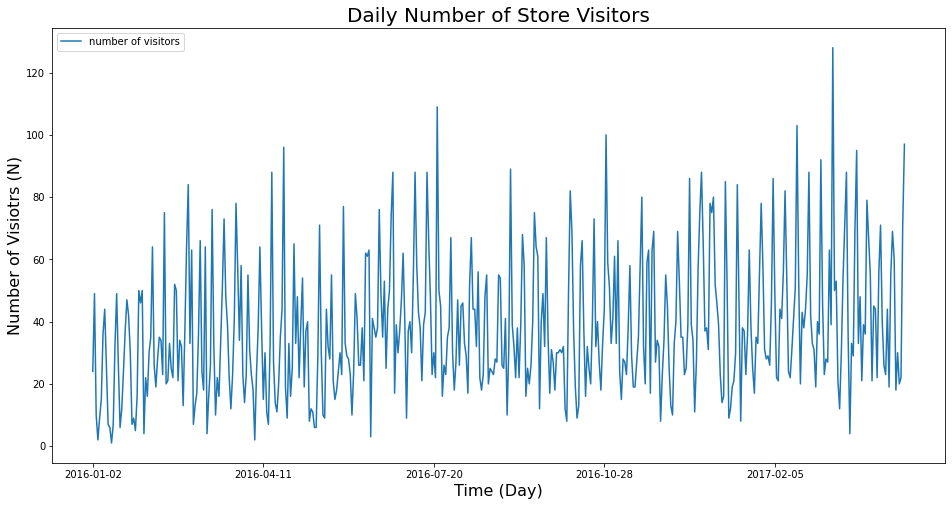

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'ds'
Y = 'y'
Label = "number of visitors"
Figsize = (16,8)
Title = "Daily Number of Store Visitors"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Number of Visiotrs (N)'
_fig_plot(df3, X, Y)

Ok, so we have a small upward trend present in the data. It seems like there are daily, weekly and probably monthly seasonality present. We have to keep these observations in mind while fitting our model. 

In [ ]:
shortX = df3[['ds', 'y']].tail(36) # keeping last three years of data
shortX = shortX.rename(columns = {'ds': 'dss', 'y':'yss'}) 
#shortY = df2.loc[shortX]
shortX.head()
#print(len(shortX), len(shortY))

dss  yss
159043  2017-03-18   71
159044  2017-03-19   88
159045  2017-03-20   35
159046  2017-03-21    4
159047  2017-03-22   33

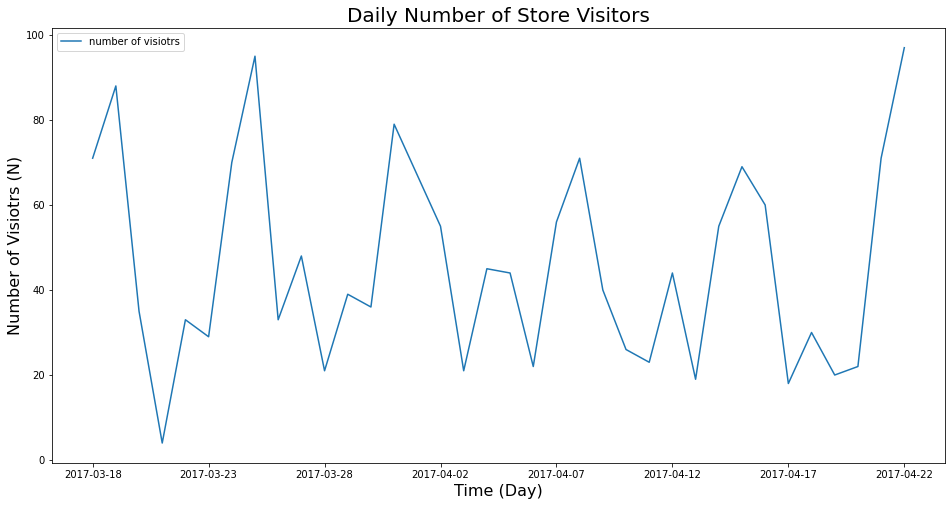

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'dss'
Y = 'yss'
Label = "number of visiotrs"
Figsize = (16,8)
Title = "Daily Number of Store Visitors"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Number of Visiotrs (N)'
_fig_plot(shortX, X, Y)

In [ ]:
# define training dataset
train = df3.copy()
# check out the first and last date to make sure holidays from which years we should include 
first = train['ds'].head(1)
last = train['ds'].tail(1)
print('Starting date: {}'.format(first),'\n\n','Ending date: {}'.format(last))

Starting date: 158602    2016-01-02
Name: ds, dtype: object 

 Ending date: 159078    2017-04-22
Name: ds, dtype: object


In [ ]:
# define and input holidays
import holidays 
holiday = pd.DataFrame([])
for date, name in sorted(holidays.US(years=[2016,2017]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

Available hyperparameters are-

* growth='linear',
* changepoints=None,
* n_changepoints=25,
* changepoint_range=0.8,
* yearly_seasonality='auto',
* weekly_seasonality='auto',
* daily_seasonality='auto',
* holidays=None,
* seasonality_mode='additive',
* seasonality_prior_scale=10,
* holidays_prior_scale=10,
* changepoint_prior_scale=0.05,
* mcmc_samples=0,
* interval_width=0.8,
* uncertainty_samples=1000,
* stan_backend=None

In [ ]:
# let's predict now
# instantiate the model and fit the timeseries
prophet = Prophet(daily_seasonality= 'auto',
                  weekly_seasonality= 'auto',
                  yearly_seasonality= 'auto', 
                  growth='linear', 
                  changepoints=None, 
                  n_changepoints=25, 
                  changepoint_range=0.8,  
                  holidays=holiday, 
                  seasonality_mode='additive', 
                  seasonality_prior_scale=10, 
                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05, 
                  mcmc_samples=0, 
                  interval_width=0.8, 
                  uncertainty_samples=1000, 
                  stan_backend=None)
prophet.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# create a future data frame 
future = prophet.make_future_dataframe(periods=30)
forecast = prophet.predict(future)

Printing outputs from Prophet prediction...
           ds       yhat  yhat_lower  yhat_upper
0 2016-01-02  59.729673   42.923366   78.713013
1 2016-01-03  32.159760   13.904222   50.813954
2 2016-01-04  15.600593   -3.423572   35.263119
3 2016-01-05  16.482566   -1.168613   34.750489
4 2016-01-06  15.895627   -1.781107   34.613282


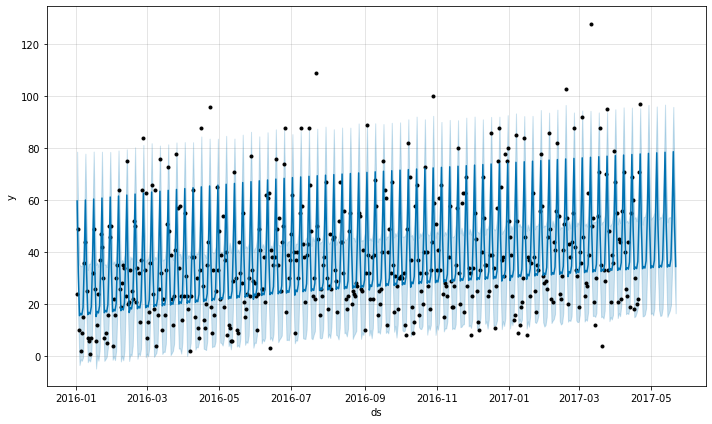

In [ ]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [ ]:
# Python
plot_plotly(prophet, forecast)

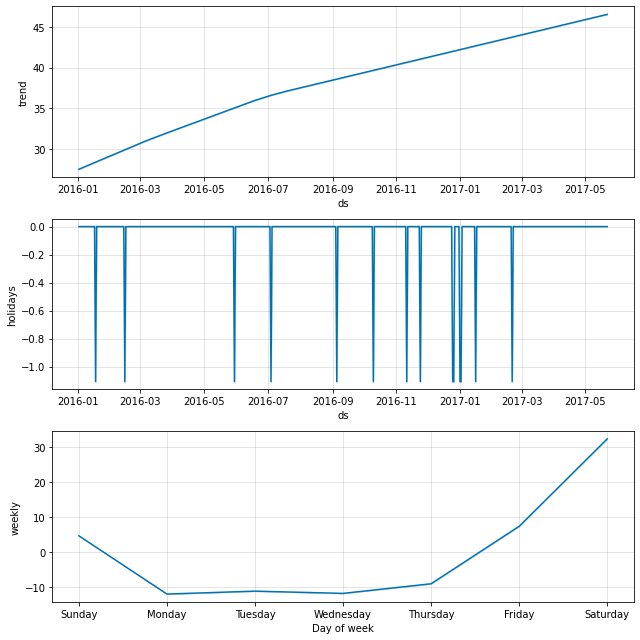

In [ ]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [ ]:
len(train)

477

In [ ]:
# use built in fbprophet evaluation function and metrix
evaluation_model = cross_validation(prophet, initial='300 days', period='30 days', horizon = '15 days')

INFO:prophet:Making 6 forecasts with cutoffs between 2016-11-08 00:00:00 and 2017-04-07 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.sort_values('rmse').head(5)

horizon         mse       rmse        mae      mape     mdape     smape  \
6  8 days   79.751122   8.930348   7.564064  0.303439  0.135661  0.229397   
8 10 days  106.743208  10.331660   8.176504  0.366865  0.147934  0.236461   
7  9 days  129.358624  11.373593   8.409945  0.459906  0.155571  0.248875   
3  5 days  152.361517  12.343481  11.153992  0.326068  0.217929  0.294846   
5  7 days  154.293776  12.421505  10.891524  0.527934  0.281587  0.368458   

   coverage  
6  0.944444  
8  0.944444  
7  0.888889  
3  0.888889  
5  0.833333

Looking into the evaluation variables, we find the model to be a fairly good predictor for our case.

In [ ]:
# create test dataset, remove last 30 days and keep it as our test
train_ = train[:447]
test = train[447:]

In [ ]:
m = Prophet(daily_seasonality= 'auto',
                  weekly_seasonality= 'auto',
                  yearly_seasonality= 'auto', 
                  growth='linear', 
                  changepoints=None, 
                  n_changepoints=25, 
                  changepoint_range=0.8,  
                  holidays=holiday, 
                  seasonality_mode='additive', 
                  seasonality_prior_scale=10, 
                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05, 
                  mcmc_samples=0, 
                  interval_width=0.8, 
                  uncertainty_samples=1000, 
                  stan_backend=None)
m.fit(train_)
# create a future data frame 
future_ = m.make_future_dataframe(periods=30)
forecast_ = m.predict(future_)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#y_true .rt\
print('Length of forcast series, train series, and original series: ', len(forecast_), len(train_), len(train))
print(' ')
y_true= test['y'].values
y_pred = forecast_['yhat'][-len(y_true):].values
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error: %.3f' % mae)

Length of forcast series, train series, and original series:  477 447 477
 
Mean Absolute Error: 11.965


In [ ]:
# check the length for both sub-series
len(y_true), len(y_pred)

(30, 30)

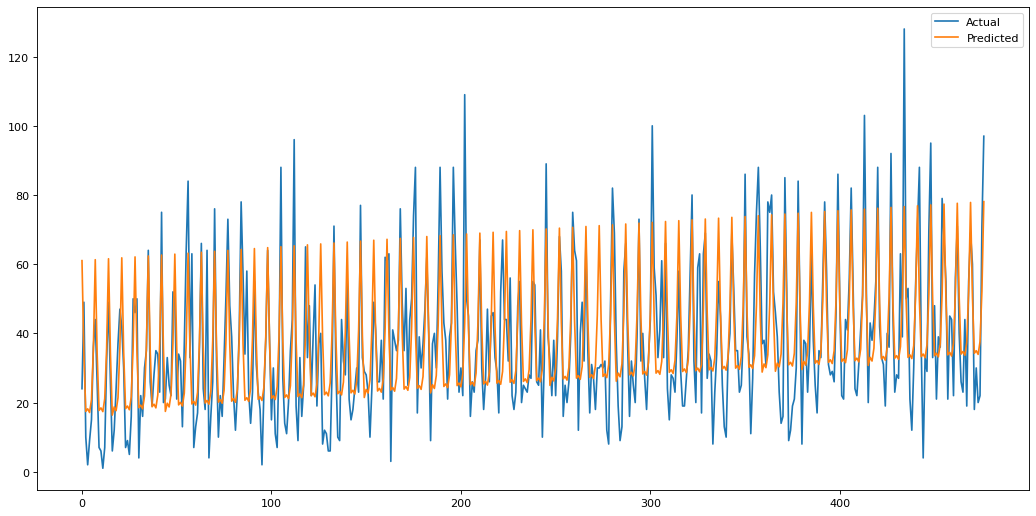

In [ ]:
# plot expected vs actual
import matplotlib.pyplot as pltt
from matplotlib.pyplot import figure
figure(figsize=(16, 8), dpi=80)

pltt.plot(train['y'].values, label='Actual')
pltt.plot(forecast_['yhat'].values, label='Predicted')
pltt.legend()
pltt.show()

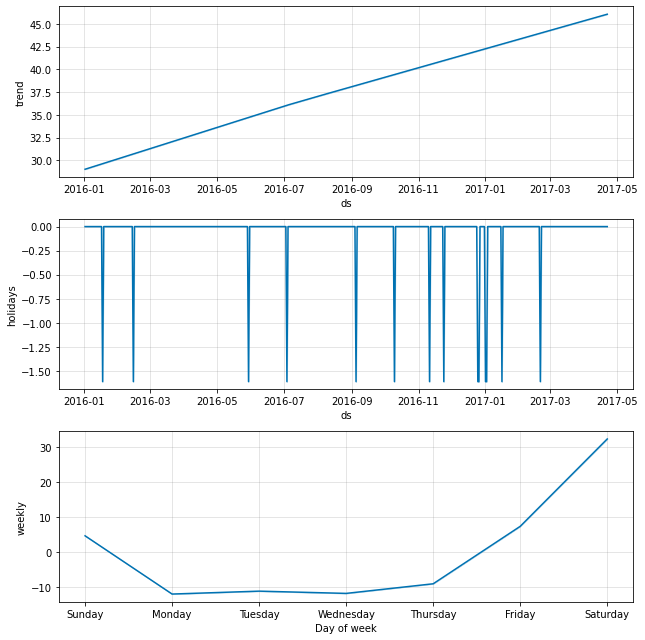

In [ ]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast_)
plt.show()

In [ ]:
# let's check if we have unique inputs 
train.nunique()

ds    477
y      93
dtype: int64

As we see, the dataset has unique dates and that's what we wanted for our time series problem.

# Covid 19 Vaccination-Immunity Prediction

For features information, visit:
https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-Jurisdi/unsk-b7fc

In [ ]:
!pip install requests
# install relevant, necessary packages
!pip install pandas
!pip install numpy
!pip install prophet
!pip install plotnine

In [ ]:
# import necessary libraries
import requests
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [ ]:
# let's load the data to colab and read it as a panda dataframe.
# Load the data file from local disk to Colab env. Run the following command and select the csv file to upload
from google.colab import files
datafile = files.upload()

Saving COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv to COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv


In [ ]:
# Let's convert the datafile into a dataframe
# Put the csv filename as filename
filename = 'COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv'
df = pd.read_csv(filename) # important to specify encoding

In [ ]:
# check total number of cells, first few rows, and descriptive stats 
def descriptive_info(df):
#  number_of_cells = df.count(axis=0, level=None, numeric_only=False)
  # Let's check the shape of the dataset
  print('Features:', df.shape[1], ' ', 'Entries:', df.shape[0])
  print('\n\n')
  print('Printing descriptive statistics...\n\n', df.describe())

In [ ]:
# now check some basic info of our dataset
descriptive_info(df)

In [ ]:
# Let's define a function to check the type of our features and check for 
# missing values in our dataset
def missing_val(df):
  print(df.info())
  print('\n\nFeatures with missing values in descending order \n\n')
  print((df.isnull().sum()/ df.shape[0]).sort_values(ascending=False))

In [ ]:
# Now apply the missing_val function
missing_val(df)

We'll focus on the column **Series_Complete_Yes** that indicates the number of people who got fully vaccinated. Because the dataset contains information for the USA, we have to check if we have state wise data or overall for the US.

In [ ]:
df.head(5)

Date  MMWR_week Location  Distributed  Distributed_Janssen  \
0  05/18/2022         20       WI     11866445               452600   
1  05/18/2022         20       AR      6316780               255200   
2  05/18/2022         20       CO     12687875               493400   
3  05/18/2022         20       FM       165900                12800   
4  05/18/2022         20       NY     46764355              1901000   

   Distributed_Moderna  Distributed_Pfizer  Distributed_Unk_Manuf  \
0              4442500             6971345                      0   
1              2650120             3411460                      0   
2              4665540             7528935                      0   
3                92440               60660                      0   
4             16537200            28326155                      0   

   Dist_Per_100K  Distributed_Per_100k_12Plus  ...  Series_Complete_5Plus  \
0         203806                       237339  ...              3827436.0   
1         209317                       247015  ...              1647616.0   
2         220324                       257045  ...              4056082.0   
3         162138                       209623  ...                57689.0   
4         240390                       278804  ...             15019842.0   

   Series_Complete_5PlusPop_Pct  Administered_5Plus  Admin_Per_100k_5Plus  \
0                          69.7          10396851.0              189311.0   
1                          58.2           4274780.0              151088.0   
2                          74.7          10845654.0              199863.0   
3                          62.2            132226.0              142453.0   
4                          82.0          39631216.0              216250.0   

   Distributed_Per_100k_5Plus  Series_Complete_Moderna_5Plus  \
0                    216070.0                      1340249.0   
1                    223260.0                       668778.0   
2                    233812.0                      1442271.0   
3                    178731.0                        32029.0   
4                    255173.0                      5022092.0   

   Series_Complete_Pfizer_5Plus  Series_Complete_Janssen_5Plus  \
0                     2185350.0                       300876.0   
1                      864291.0                       113183.0   
2                     2298085.0                       312790.0   
3                       13102.0                        12537.0   
4                     8735293.0                      1255701.0   

   Series_Complete_Unk_Manuf_5Plus  Second_Booster  
0                            961.0             NaN  
1                           1364.0             NaN  
2                           2936.0             NaN  
3                             21.0             NaN  
4                           6756.0             NaN  

[5 rows x 83 columns]

So, we have statewise data. Let's focus on California (CA) as it was the worst affected state in USA. We need to filter our data to keep only information on CA.

In [ ]:
df2 = df[df['Location'] == 'CA']

In [ ]:
df2.head()

Date  MMWR_week Location  Distributed  Distributed_Janssen  \
61   05/18/2022         20       CA     91690855              3730500   
101  05/17/2022         20       CA     91570655              3730400   
189  05/16/2022         20       CA     91528055              3730400   
246  05/15/2022         20       CA     91487555              3730400   
278  05/14/2022         19       CA     91484555              3730400   

     Distributed_Moderna  Distributed_Pfizer  Distributed_Unk_Manuf  \
61              32974680            54985675                      0   
101             32901280            54938975                      0   
189             32889880            54907775                      0   
246             32889880            54867275                      0   
278             32889880            54864275                      0   

     Dist_Per_100K  Distributed_Per_100k_12Plus  ...  Series_Complete_5Plus  \
61          232057                       272514  ...             28600838.0   
101         231753                       272157  ...             28595947.0   
189         231645                       272030  ...             28593136.0   
246         231542                       271910  ...             28590611.0   
278         231535                       271901  ...             28584839.0   

     Series_Complete_5PlusPop_Pct  Administered_5Plus  Admin_Per_100k_5Plus  \
61                           77.0          75861619.0              204322.0   
101                          77.0          75800137.0              204156.0   
189                          77.0          75769404.0              204073.0   
246                          77.0          75741901.0              203999.0   
278                          77.0          75665853.0              203794.0   

     Distributed_Per_100k_5Plus  Series_Complete_Moderna_5Plus  \
61                     246955.0                      9814871.0   
101                    246632.0                      9813239.0   
189                    246517.0                      9812276.0   
246                    246408.0                      9811658.0   
278                    246400.0                      9809878.0   

     Series_Complete_Pfizer_5Plus  Series_Complete_Janssen_5Plus  \
61                     16693937.0                      2087256.0   
101                    16690843.0                      2087091.0   
189                    16689065.0                      2087022.0   
246                    16687231.0                      2086950.0   
278                    16683394.0                      2086798.0   

     Series_Complete_Unk_Manuf_5Plus  Second_Booster  
61                            4774.0             NaN  
101                           4774.0             NaN  
189                           4773.0             NaN  
246                           4772.0             NaN  
278                           4769.0             NaN  

[5 rows x 83 columns]

Now, we have data only on CA. Let's check out more information on the data.

In [ ]:
df2.shape

(521, 83)

In [ ]:
# This Function is to prepare the dataset for Fb Prophet
#ds, save the name of date column as ds
#y, save the name of column we are interested in as y
def prepare_data(df, ds, y):
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
  df = df[[ds, y]]
  df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
  df['ds'] = pd.to_datetime(df.ds)
  df['ds'] = df['ds'].dt.date
  print('The series is ready for use.\n')
  return df

In [ ]:
# Use the function to prepare the dataframe to feed into fbprophet
# df = series, ds = the time variable name from the dataframe (string), 
# y = intended variable name for prediction from the dataframe, (string)
df3 = prepare_data(df2, ds = 'Date', y = 'Series_Complete_Yes') 
print(df3.head())
print('')
print('The length of your series is: ', len(df3))

The series is ready for use.

             ds         y
61   2022-05-18  28621605
101  2022-05-17  28616528
189  2022-05-16  28613626
246  2022-05-15  28610997
278  2022-05-14  28604955

The length of your series is:  521


Because our data is in descending order, we need to sort it before useing.

In [ ]:
df3.sort_values(by = ['ds'])

ds         y
33603  2020-12-14         0
33498  2020-12-15         0
33444  2020-12-16         0
33401  2020-12-17         0
33323  2020-12-18         0
...           ...       ...
278    2022-05-14  28604955
246    2022-05-15  28610997
189    2022-05-16  28613626
101    2022-05-17  28616528
61     2022-05-18  28621605

[521 rows x 2 columns]

OK! We got our data in the correct format. Now let's plot it to analyze the series.

In [ ]:
## function to Plot the prepared data
def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

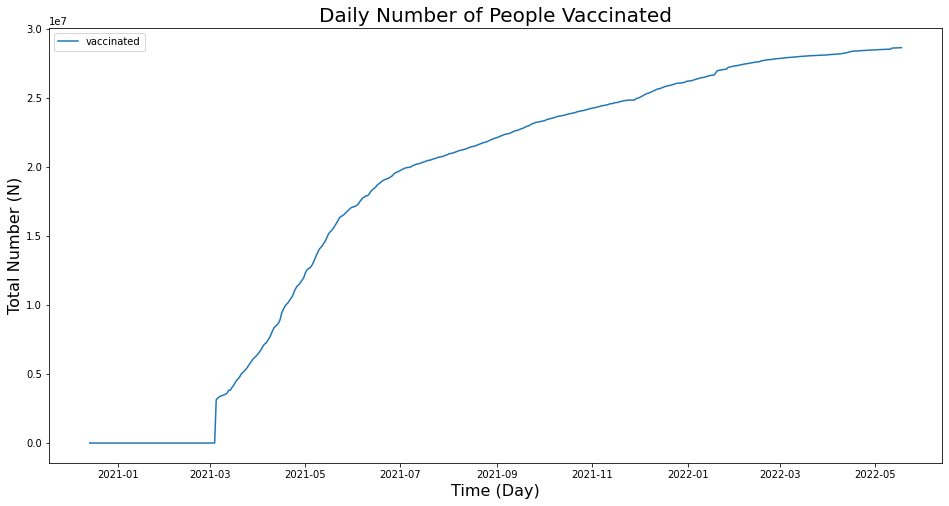

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'ds'
Y = 'y'
Label = "vaccinated"
Figsize = (16,8)
Title = "Daily Number of People Vaccinated"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Total Number (N)'
_fig_plot(df3, X, Y)

We see that there are several days in the beginning that have y = 0. that means no vaccination was done during that time frame. Because it does not really help in our predicition, we can get rid of that here before further analysis.

In [ ]:
df4 = df3[df3['y'] != 0]

In [ ]:
df4.shape

(440, 2)

So, we dropped initial 81 days because there was no vaccination at that time there.

In [ ]:
series = df4.copy() # let's generalize the series name for future use so we don't confuse it

In [ ]:
# Quick look at how the price changes over time
import plotly.express as px
px.area(series, x='ds', y='y', width=800, height=400)

In [ ]:
shortX = series[['ds', 'y']].tail(60)
shortX = shortX.rename(columns = {'ds': 'dss', 'y':'yss'}) 

In [ ]:
# provide variable names and other required inputs to plot using the function
import plotly.express as px
px.area(shortX, x='dss', y='yss', width=800, height=400)

From visualizing the data, we don't really see any seasonality here. Only an upward trend.

In [ ]:
# let's predict now
# instantiate the model and fit the timeseries

prophet = Prophet(daily_seasonality= False,
                  weekly_seasonality= False,
                  yearly_seasonality= False, 
                  growth='linear', 
                  changepoints=None, 
                  n_changepoints=25, 
                  changepoint_range=0.8,  
                  holidays=None, 
                  seasonality_mode='additive', 
                  seasonality_prior_scale=10, 
                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05, 
                  mcmc_samples=0, 
                  interval_width=0.8, 
                  uncertainty_samples=1000, 
                  stan_backend=None)
prophet.fit(series)

In [ ]:
# create a future data frame for next two months
future = prophet.make_future_dataframe(periods=60)
forecast = prophet.predict(future)

Printing outputs from Prophet prediction...
           ds          yhat    yhat_lower    yhat_upper
0 2021-03-05  2.987097e+06  2.917486e+06  3.063030e+06
1 2021-03-06  3.102072e+06  3.032696e+06  3.174675e+06
2 2021-03-07  3.217047e+06  3.142846e+06  3.284559e+06
3 2021-03-08  3.332022e+06  3.258058e+06  3.402856e+06
4 2021-03-09  3.446998e+06  3.374251e+06  3.512281e+06


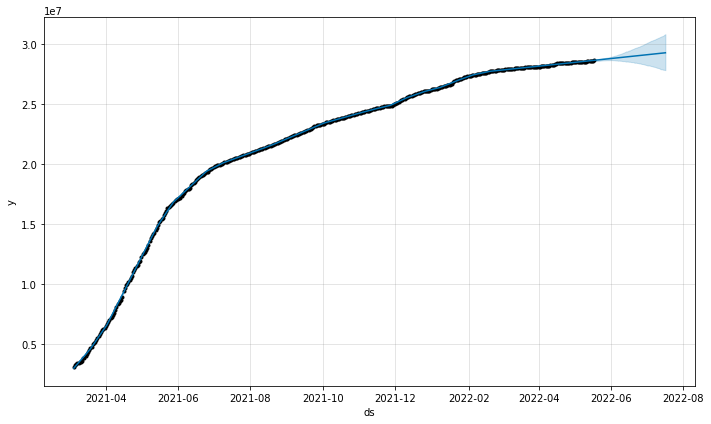

In [ ]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [ ]:
# Python
plot_plotly(prophet, forecast)

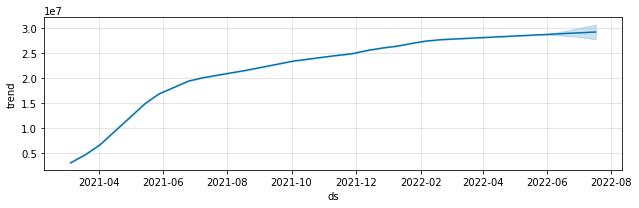

In [ ]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [ ]:
# use built in fbprophet evaluation function and metrix
evaluation_model = cross_validation(prophet, initial='300 days', period='30 days', horizon = '5')

INFO:prophet:Making 5 forecasts with cutoffs between 2022-01-17 23:59:59.999999995 and 2022-05-17 23:59:59.999999995


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.sort_values('rmse').head()

horizon           mse           rmse            mae  \
0 0 days 00:00:00.000000005  2.102454e+10  144998.430752  108944.719711   

       mape     mdape    smape  coverage  
0  0.003934  0.003724  0.00392       0.4

# Ecommerce Daily Orders Forecasting 

In [ ]:
# install relevant, necessary packages
!pip install pandas
!pip install numpy
!pip install prophet
!pip install plotnine

In [ ]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [ ]:
# Load the data file from local disk to Colab env. Run the following command and select the csv file to upload
from google.colab import files
datafile = files.upload()

Saving ecommerce_data.csv to ecommerce_data.csv


In [ ]:
# Let's convert the datafile into a dataframe
df = pd.read_csv('ecommerce_data.csv', encoding='latin-1') # important to specify encoding

In [ ]:
# check total number of cells, first few rows, and descriptive stats 
def descriptive_info(df):
  number_of_cells = df.count(axis=0, level=None, numeric_only=False)
  print('Total number of cells the datafile has: \n' + str(number_of_cells))
  print('\n')
  print('Printing descriptive statistics...\n\n', df.describe())

In [ ]:
descriptive_info(df)

Total number of cells the datafile has: 
date          523684
product_id    523684
city_id       523684
orders        523684
dtype: int64


Printing descriptive statistics...

           product_id        city_id         orders
count  523684.000000  523684.000000  523684.000000
mean     3778.827025      16.301281      20.231288
std      2199.677466       8.549154     197.371830
min         0.000000       0.000000       1.000000
25%      1875.000000      11.000000       1.000000
50%      3734.000000      16.000000       3.000000
75%      5713.000000      25.000000      11.000000
max      7620.000000      30.000000  126919.000000


In [ ]:
# Let's define a function to check the type of our features and check for 
# missing values in our dataset
def missing_val(df):
  print(df.info())
  print('\n\nFeatures with missing values in descending order \n\n')
  print((df.isnull().sum()/ df.shape[0]).sort_values(ascending=False))

In [ ]:
missing_val(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523684 entries, 0 to 523683
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        523684 non-null  object
 1   product_id  523684 non-null  int64 
 2   city_id     523684 non-null  int64 
 3   orders      523684 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 16.0+ MB
None


Features with missing values in descending order 


date          0.0
product_id    0.0
city_id       0.0
orders        0.0
dtype: float64


Good news! no missing values.

In [ ]:
df.head()

date  product_id  city_id  orders
0  2019-12-16        1897       26       2
1  2019-12-16        4850       26       4
2  2019-12-16        2466       26       1
3  2019-12-16         637       26       1
4  2019-12-16        3497       26     184

Ok, so we have data on the same date from different cities on differenet products. We need to take care of this to be able to run as a time series using fbprophet. Let's group by date, & city to get total orders for a single product on a specific day in a city.  

In [ ]:
df2 = df.copy() # make a copy to keep our original data unchanged

In [ ]:
df2 = df2.groupby(["city_id","date"])["orders"].sum().reset_index() # very important to include .reset_index() to keep original columns

In [ ]:
df2.head()

city_id        date  orders
0        0  2018-07-13     104
1        0  2018-07-14     140
2        0  2018-07-15     108
3        0  2018-07-16     116
4        0  2018-07-17     148

In [ ]:
df2.shape

(14263, 3)

Ok, now we have data from different cities. We will continue with a single city for our analysis.

In [ ]:
# us this cell to check which city has how many dates
#df3 = df2.copy()
# let's check the group with maximum number of data
#(df3.groupby('city_id').size()).sort_values(ascending = False)

In [ ]:
df4 = df2[df2['city_id'] == 14] # we'll use data from only city 14

In [ ]:
df4.head()

city_id        date  orders
6533       14  2018-07-10    5860
6534       14  2018-07-11    2500
6535       14  2018-07-12    2553
6536       14  2018-07-13    2616
6537       14  2018-07-14    2814

In [ ]:
# This Function is to prepare the dataset for Fb Prophet
#ds, save the name of date column as ds
#y, save the name of column we are interested in as y
def prepare_data(df, ds, y):
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
  df = df[[ds, y]]
  df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
  df['ds'] = pd.to_datetime(df.ds)
  df['ds'] = df['ds'].dt.date
  print('The series is ready for use.\n')
  return df

In [ ]:
# Use the function to prepare the dataframe to feed into fbprophet
# df = series, ds = the time variable name from the dataframe (string), 
# y = intended variable name for prediction from the dataframe, (string)
series = prepare_data(df4, ds = 'date', y = 'orders') 
print(series.head())
print('')
print('The length of your series is: ', len(series))

The series is ready for use.

              ds     y
6533  2018-07-10  5860
6534  2018-07-11  2500
6535  2018-07-12  2553
6536  2018-07-13  2616
6537  2018-07-14  2814

The length of your series is:  471


In [ ]:
# reset index and check first and last date in our series
print('First date {}\n and Last date {}\n'.format(series.head(1)['ds'], series.tail(1)['ds']))

First date 6533    2018-07-10
Name: ds, dtype: object
 and Last date 7003    2019-12-16
Name: ds, dtype: object



Now that our series is ready let's continue exploring it and finally fitting it to our model.

In [ ]:
# Quick look at how the price changes over time
import plotly.express as px
px.area(series, x='ds', y='y', width=800, height=400)

In [ ]:
## function to Plot the prepared data
def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

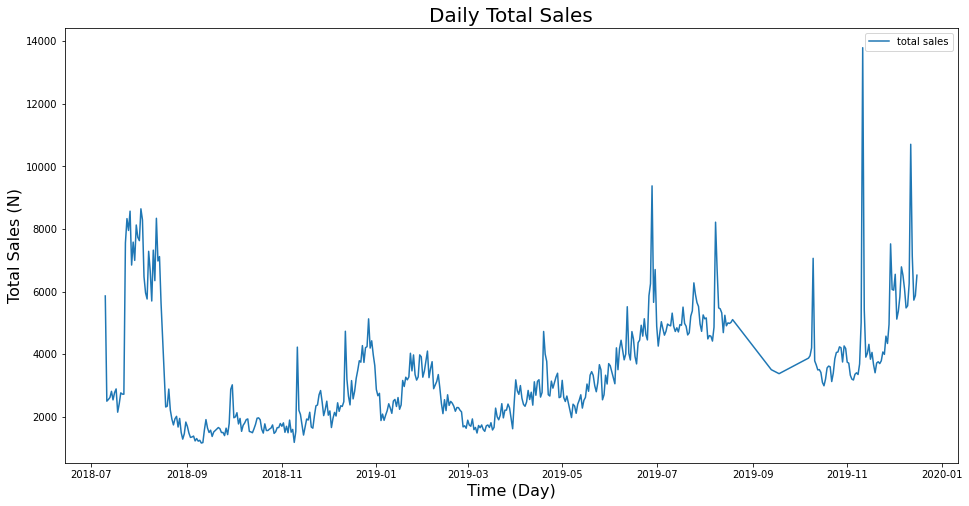

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'ds'
Y = 'y'
Label = "total sales"
Figsize = (16,8)
Title = "Daily Total Sales"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Total Sales (N)'
_fig_plot(series, X, Y)

There is an upward trend and some seasonality present in this series.

In [ ]:
# let's predict now
# instantiate the model and fit the timeseries

prophet = Prophet(daily_seasonality= 'auto',
                  weekly_seasonality= True,
                  yearly_seasonality= 'auto', 
                  growth='linear', 
                  changepoints=None, 
                  n_changepoints=25, 
                  changepoint_range=0.8,  
                  holidays=None, 
                  seasonality_mode='additive', 
                  seasonality_prior_scale=10, 
                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05, 
                  mcmc_samples=0, 
                  interval_width=0.8, 
                  uncertainty_samples=1000, 
                  stan_backend=None)
prophet.fit(series)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# create a future data frame 
future = prophet.make_future_dataframe(periods=30)
forecast = prophet.predict(future)

Printing outputs from Prophet prediction...
           ds         yhat   yhat_lower   yhat_upper
0 2018-07-10  4402.178845  2650.821426  6146.231358
1 2018-07-11  4437.084876  2743.228897  6096.286751
2 2018-07-12  4540.684029  2632.956903  6370.339534
3 2018-07-13  4500.428379  2786.998203  6211.078284
4 2018-07-14  4331.636368  2590.983802  6076.043993


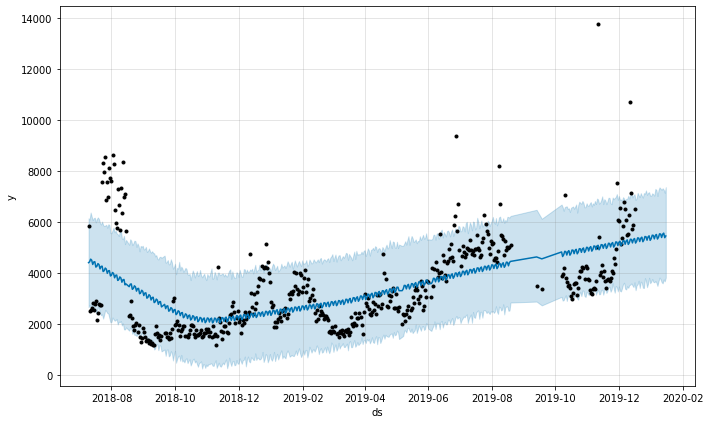

In [ ]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [ ]:
# let's use the function to plot it to be able to visualize in different windows
plot_plotly(prophet, forecast)

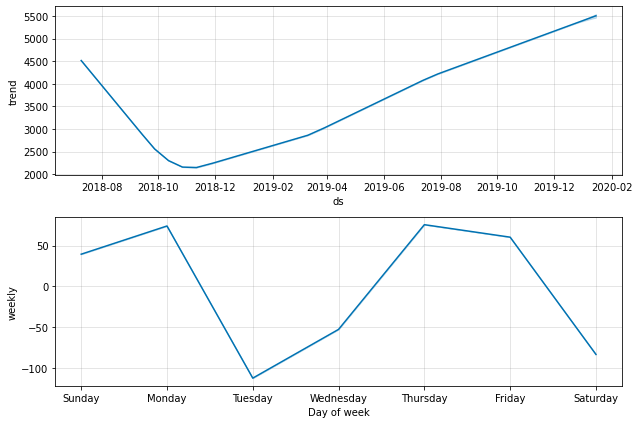

In [ ]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [ ]:
# use built in fbprophet evaluation function and metrix
evaluation_model = cross_validation(prophet, initial='300 days', period='30 days', horizon = '15')

INFO:prophet:Making 8 forecasts with cutoffs between 2019-05-15 23:59:59.999999985 and 2019-12-15 23:59:59.999999985


  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
evaluation_metrix = performance_metrics(evaluation_model)
#evaluation_metrix.sort_values('rmse').head(5)
evaluation_metrix.head()

horizon           mse         rmse          mae      mape  \
0 0 days 00:00:00.000000015  2.128447e+06  1458.919885  1123.172426  0.294387   

      mdape     smape  coverage  
0  0.187977  0.251641      0.75